# **Pipeline I**

*No significant changes were made to the first pipeline, so this section does not need to be run can be skipped. Changes that were made to the first pipeline are discussed in the second Pipeline.*

### **Part I: Data Collection**

People take great pride in their consumption choices, such as music tastes. My good friend Ibrahim (henceforth in this assignment referred to as Ibbi) and I share a similar (and, in our opinion, great) taste in music. To keep discovering more fantastic music, since last summer we have maintained shared playlists on Spotify, adding songs others might like.

The premise behind creating such playlists was that our music tastes are virtually identical, so we expected very little information about the class of the data (as being added by me or Ibbi) to be encoded in the data. However, of course, we wouldn't add songs that we already know the other person likes, so there is indeed some information about our respective diverging tastes embedded within. Capturing this nuanced information is the aim of our project.

The data was collected from five playlists made by Ibbi and me for sharing music, which are attached here (no judgment, please). Since Ibbi had disproportionately more songs in these playlists, I also included data from my "Liked Music" playlist. This data does not arise the same way as the shared playlist data but was used considering there needed to be more data to train a model on our music tastes.

In [ ]:
import requests
import base64
import ast
import webbrowser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlencode, parse_qs, urlsplit

In [ ]:
# Ideally API personal data would not be shared, but I have left it here.

# Spotify API credentials
client_id = '2d83d4418ef84e179f27f6a905c9c3f0'
client_secret = '8960c2e6678c472789fdcdc94e6a2916'
redirect_uri = 'http://127.0.0.1/'

# Spotify API URLs
auth_url = 'https://accounts.spotify.com/authorize'
token_url = 'https://accounts.spotify.com/api/token'
base_url = 'https://api.spotify.com/v1/'

# Playlist IDs
playlist_ids = ['6wdlKSxFg2LL3OFh3FTanu', '5ZNlj2qyIAShA9r1yYEbRx', '099iz4zQvOZVEfWjM8SQCN', '1A24A0nfc7RCJO5FrHEe21', '4zIktvU6tdfeSSfUoANcPK']

In [ ]:
def get_user_authorization(client_id, redirect_uri):
    # Define access scope
    scope = 'playlist-read-private playlist-read-collaborative user-library-read'
    # Prepare authorization query
    query = urlencode({
        'response_type': 'code',
        'client_id': client_id,
        'scope': scope,
        'redirect_uri': redirect_uri
    })
    # Construct authorization URL
    auth_request_url = f'{auth_url}?{query}'
    print("Please go to this URL and authorize access:", auth_request_url)
    # Get authorization code from user
    code = input("Paste the authorization code here: ")
    return code

def get_access_token(client_id, client_secret, code, redirect_uri):
    # Encode client credentials
    auth_string = f'{client_id}:{client_secret}'
    auth_bytes = auth_string.encode('ascii')
    auth_b64 = base64.b64encode(auth_bytes).decode('ascii')
    # Setup request headers
    headers = {
        'Authorization': f'Basic {auth_b64}',
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    # Setup request body
    body = {
        'grant_type': 'authorization_code',
        'code': code,
        'redirect_uri': redirect_uri
    }
    # Exchange code for access token
    response = requests.post(token_url, headers=headers, data=body)
    response.raise_for_status()
    return response.json().get('access_token')

def get_playlist_tracks(token, playlist_id):
    """ Get all tracks from a playlist, including who added them, handling pagination """
    # Set authorization headers
    headers = {
        'Authorization': f'Bearer {token}',
        'Content-Type': 'application/json'
    }
    all_tracks = []  # Initialize list to store all tracks
    playlist_url = f'{base_url}playlists/{playlist_id}/tracks'  # Initial API endpoint

    while playlist_url:  # Loop through paginated results
        response = requests.get(playlist_url, headers=headers)  # API request
        json_response = response.json()  # Parse JSON response
        all_tracks.extend(json_response['items'])  # Add current page of tracks to list
        playlist_url = json_response.get('next')  # Get next page URL, if exists

    return all_tracks  # Return compiled list of tracks

def get_audio_features(token, track_id):
    """ Get audio features for a track """
    # Set authorization headers
    headers = {
        'Authorization': f'Bearer {token}',
        'Content-Type': 'application/json'
    }
    audio_features_url = f'{base_url}audio-features/{track_id}'  # API endpoint for audio features
    response = requests.get(audio_features_url, headers=headers)  # API request
    return response.json()  # Return parsed JSON response

Since I am also including liked songs data which is more personal, spotify requires additional authentication.

To get the auth, use the code cell below, to get the link. Go to the link and take code in the hyperlink and paste it in the test box below.

In [ ]:
# Main execution
code = get_user_authorization(client_id, redirect_uri)
token = get_access_token(client_id, client_secret, code, redirect_uri)

Please go to this URL and authorize access: https://accounts.spotify.com/authorize?response_type=code&client_id=2d83d4418ef84e179f27f6a905c9c3f0&scope=playlist-read-private+playlist-read-collaborative+user-library-read&redirect_uri=http%3A%2F%2F127.0.0.1%2F
Paste the authorization code here: AQAtUd2zYtJ67vpSc9A3UCr0AjY_6K8jBGQqWvx_RfuwxdKn18xD-Xw0GEhs7SNfWjcyYfcyHS4j3CQ08EQ5LRfPhcMsvkmXWxKFCUhG0xTjQBAYnhdB2iuVUyHewLkmPo4jZbyomWcOE6atLzQ8CweAFLV9rnmkE8s6YAdKYhb2EZ5cnjz6FNvAexWi-JPj-e7q_mXhb2E1tVkr2LNPIX8zvlB5BYXrFuAYu8pEmt27MpuACt9Wc4AVtvo


### **Part II: Loading Data**

Data regarding our music tastes was accessed using the Spotify API. This included separate API calls to retrieve the release year of the album each song was on and the genres of the song's artist (since Spotify does not provide direct genre information for songs) due to the structure of the API. The data was stored as pandas dataframes.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
all_tracks_data = []

for playlist_id in playlist_ids:
    playlist_tracks = get_playlist_tracks(token, playlist_id)

    for item in playlist_tracks:
        track = item['track']
        track_id = track['id']

        audio_features = get_audio_features(token, track_id)
        added_by = item['added_by']['id'] if item['added_by'] else 'Unknown'
        track_name = track['name']
        artist_names = ', '.join([artist['name'] for artist in track['artists']])
        album_name = track['album']['name']

        # Each track is a dictionary added to the list
        track_data = {
            'Playlist ID': playlist_id,
            'Track ID': track_id,
            'Track Name': track_name,
            'Artists': artist_names,
            'Album Name': album_name,
            'Added By': added_by
        }

        # Merge the audio features into the track data
        track_data.update(audio_features)

        all_tracks_data.append(track_data)

# Convert the list of dictionaries to a pandas DataFrame
tracks_df = pd.DataFrame(all_tracks_data)

In [ ]:
def get_liked_songs_data(token):
    # Set up headers for API authorization
    headers = {
        'Authorization': f'Bearer {token}',
        'Content-Type': 'application/json'
    }
    all_tracks_data = []  # Initialize list to store all liked songs data
    liked_songs_url = f'{base_url}me/tracks'  # API endpoint for fetching liked songs

    while liked_songs_url:  # Loop to handle pagination
        response = requests.get(liked_songs_url, headers=headers)  # Make API request
        json_response = response.json()  # Parse response

        # Check if response contains 'items' key
        if 'items' not in json_response:
            print("Error in fetching data: 'items' key not found in response.")
            print("Response received:", json_response)
            break  # Exit loop if 'items' key is missing

        for item in json_response['items']:  # Iterate through each liked song
            track = item['track']
            track_id = track['id']
            audio_features = get_audio_features(token, track_id)  # Fetch audio features for the track
            track_name = track['name']
            artist_names = ', '.join([artist['name'] for artist in track['artists']])  # Join artist names
            album_name = track['album']['name']

            # Compile track data
            track_data = {
                'Playlist ID': 'Liked Songs',
                'Track ID': track_id,
                'Track Name': track_name,
                'Artists': artist_names,
                'Album Name': album_name,
                'Added By': 'User'
            }

            track_data.update(audio_features)  # Add audio features to track data
            all_tracks_data.append(track_data)  # Add track data to the list

        liked_songs_url = json_response.get('next')  # Get URL for next page of results

    return all_tracks_data  # Return list of all liked songs data

In [ ]:
# Use this function in your main execution flow
liked_songs_data = get_liked_songs_data(token)
tracks_df_liked_songs = pd.DataFrame(liked_songs_data)

# Merging with existing tracks DataFrame
tracks_df = pd.concat([tracks_df, tracks_df_liked_songs], ignore_index=True)

In [ ]:
def get_artist_genre(df, token):
    """Fetch genres for artists in a DataFrame."""
    genres = []
    for artist_name in df['Artists'].unique():
        search_url = f'https://api.spotify.com/v1/search?q={artist_name}&type=artist'
        response = requests.get(search_url, headers={'Authorization': f'Bearer {token}'})
        response.raise_for_status()
        data = response.json()
        artist_genre = data['artists']['items'][0]['genres']
        genres.append(artist_genre if artist_genre else ['Genre not found'])
    return genres

def get_album_release_date(df, token):
    """Fetch album release dates for albums in a DataFrame."""
    release_dates = []
    for album_name in df['Album Name'].unique():
        search_url = f'https://api.spotify.com/v1/search?q={album_name}&type=album'
        response = requests.get(search_url, headers={'Authorization': f'Bearer {token}'})
        response.raise_for_status()
        data = response.json()
        album_date = data['albums']['items'][0]['release_date']
        release_dates.append(album_date if album_date else 'Release date not found')
    return release_dates

In [ ]:
years = get_album_release_date(tracks_df, token)

# Extract just the year from each date
years = [date.split('-')[0] for date in years]

In [ ]:
# Step 1: Create DataFrame from years list
years_df = pd.DataFrame(years, columns=['Album Year']).astype('int')

# Step 2: Get unique album names from tracks_df
unique_albums_df = pd.concat([pd.DataFrame(tracks_df['Album Name'].unique(), columns = ['Album Name']), years_df], axis = 1)

# Merge the DataFrames on 'Album Name'
tracks_df = pd.merge(tracks_df, unique_albums_df, on='Album Name', how='outer')

In [ ]:
genres = get_artist_genre(tracks_df, token)

In [ ]:
def one_hot_encode_and_sum(list_of_lists):
    # Flatten the list of lists
    flat_list = [item for sublist in list_of_lists for item in sublist]

    # Reshape flat_list for OneHotEncoder
    flat_list = np.array(flat_list).reshape(-1, 1)

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse=False)

    # Fit and transform the flat list
    encoded = encoder.fit_transform(flat_list)

    # Sum the one-hot vectors for each sublist and store as a list
    summed_2d_list = []
    start = 0
    for sublist in list_of_lists:
        end = start + len(sublist)
        # Convert summed numpy arrays to lists before appending
        summed_2d_list.append(encoded[start:end].sum(axis=0).tolist())
        start = end

    return summed_2d_list

In [ ]:
# One-hot encode and sum the list of genres
summed_genres = one_hot_encode_and_sum(genres)

# tracks_df is your original DataFrame and summed_genres is the numpy array
# First, ensure that each artist in tracks_df has a corresponding genre vector in summed_genres

# Step 1: Create a mapping of artists to genre vectors
artists = tracks_df['Artists'].unique()  # Get unique artists
genre_vectors = list(summed_genres)  # Convert each row of summed_genres into a list of arrays

# Create a new DataFrame to hold this information
artist_genre_map_df = pd.DataFrame({
    'Artists': artists,
    'GenreVectors': genre_vectors
})

# Step 2: Merge this new DataFrame with the original tracks_df on 'Artists'
tracks_df = pd.merge(tracks_df, artist_genre_map_df, on='Artists', how='left')

# Drop the specified columns
tracks_df.drop(['id', 'uri', 'track_href', 'analysis_url', 'Track ID', 'Playlist ID', 'Album Name'], axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Replace the 'Added By' user IDs with names
tracks_df['Added By'] = tracks_df['Added By'].replace({
    '31lxrgyrddgk67clyurkw4nkol5q': 'Saad',
    'User': 'Saad',
    '31tkfyermvgnam7zaypbbag44cey': 'Ibbi',
})

**New Data**

In [ ]:
# */New Code\*

# Musixmatch API key
api_key = "eae6afc6b15890231c76b3bbc6160c96"

In [ ]:
# First search track by artist and song title, then using unique track id to find track lyrics

def search_track_id(track_name, artist_name):
    search_url = "https://api.musixmatch.com/ws/1.1/track.search"
    params = {
        "apikey": api_key,
        "q_track": track_name,
        "q_artist": artist_name,
        "page_size": 1,
        "page": 1,
        "s_track_rating": "desc"
    }
    response = requests.get(search_url, params=params)
    data = response.json()
    track_list = data['message']['body']['track_list']
    return track_list[0]['track']['track_id'] if track_list else None

# Function to fetch lyrics by track ID
def get_lyrics(track_id):
    lyrics_url = f"https://api.musixmatch.com/ws/1.1/track.lyrics.get"
    params = {
        "apikey": api_key,
        "track_id": track_id
    }
    response = requests.get(lyrics_url, params=params)
    data = response.json()
    lyrics = data['message']['body']['lyrics']['lyrics_body'] if data['message']['body'] else None
    return lyrics

# Adding lyrics to the DataFrame
tracks_df['Lyrics'] = tracks_df.apply(lambda x: get_lyrics(search_track_id(x['Track Name'], x['Artists'])) if search_track_id(x['Track Name'], x['Artists']) else 0.5, axis=1)

In [ ]:
# Print the updated DataFrame
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track Name        338 non-null    object 
 1   Artists           338 non-null    object 
 2   Added By          338 non-null    object 
 3   danceability      338 non-null    float64
 4   energy            338 non-null    float64
 5   key               338 non-null    int64  
 6   loudness          338 non-null    float64
 7   mode              338 non-null    int64  
 8   speechiness       338 non-null    float64
 9   acousticness      338 non-null    float64
 10  instrumentalness  338 non-null    float64
 11  liveness          338 non-null    float64
 12  valence           338 non-null    float64
 13  tempo             338 non-null    float64
 14  type              338 non-null    object 
 15  duration_ms       338 non-null    int64  
 16  time_signature    338 non-null    int64  
 1

**Save Data**

In [ ]:
# Drop duplicated to prevent overfitting
tracks_df = tracks_df.drop_duplicates(subset='Track Name', keep='first')

In [ ]:
tracks_df.to_csv('tracks.csv', index=False)

**Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
tracks_df = pd.read_csv('/content/tracks.csv')

In [ ]:
# */New Code\*
# Perform train-test split
train_df, test_df = train_test_split(tracks_df, test_size=0.25, random_state=40)

# Add a column to indicate whether a row belongs to the train or test set
test_df['Type'] = 'test'
train_df['Type'] = 'train'

# Merge the two DataFrames
tracks_df = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
tracks_df.to_csv('tracks.csv', index=False)

### **Part III: Data Cleaning**

To clean the data, I removed duplicates, such as songs in my likes and the playlist, to prevent overfitting the model by training it on the same data point twice. Dates were simplified to their respective years only, which streamlined the temporal aspect of our dataset.

Addressing genre data presented a unique challenge. Spotify returns a list of genre names for each artist, culminating in ~300 unique genres across all songs in our dataset. Each artist's genres were represented as a list of strings. To manage this, each genre in the artist's list was vectorized across all unique genres, resulting in numerical arrays for each artist. The arrays for artists with multiple genres were then aggregated, aiming to capture the full spectrum of their musical styles.

Directly using the vectorized large and sparse matrix would be impractical for training a simple machine learning system with limited data points. Dimensionality reduction was necessary, yet traditional methods like PCA were ineffective due to the lack of linear correlations among genres.

I utilized [Uniform Manifold Approximation and Projection (UMAP)](https://umap-learn.readthedocs.io/en/latest/), an effective technique for dimensionality reduction in datasets where linear relationships may not exist. UMAP excels at preserving the high-dimensional data's structural integrity when mapped to a lower-dimensional space, facilitating the clustering of songs with similar or overlapping genres. However, introducing training and test data to UMAP simultaneously could lead to cross-contamination, as the model should ideally only learn from the training data as in actual model deployment, where we are blind to extrinsic test data at deployment. I split the dataset into training and test subsets to mitigate this, fitting UMAP exclusively on the training data. This approach allowed me to use the derived mapping to transform the training and testing data separately.

K-means clustering on the reduced dataset revealed clusters that approximately corresponded to similar genres, despite UMAP's lack of explicit genre knowledge—relying solely on the likelihood of genre co-occurrence. Intriguingly, these clusters also displayed uneven distributions of songs added by me and Ibbi, unveiling our preferences for specific genres.

[Chatgpt](https://chat.openai.com/share/ca1d3941-c845-4117-b783-6b6b2e1b1248), for example, described these genres as:
- Cluster 0: Classic Rock, Pop Rock
- Cluster 1: Jazz Fusion, World Music
- Cluster 2: Indie Electronic, Dream Pop
- Cluster 3: Soul, Disco

**Genre Data**

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=5883206be2d9cc516c99957cc7dd392d32cceb0a8c0be60476692f3ec767acb6
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import matplotlib.pyplot as plt
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Convert Genre Vectors to numpy array for UMAP
genre_vectors = np.stack(train_df["GenreVectors"].values)

In [ ]:
# Fit the UMAP on training data only, decrease dimensions from 300 to 3
embedder = UMAP(n_components=3)
embedder.fit(genre_vectors)

UMAP(n_components=3, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
# Transform the training data
embedding = embedder.transform(genre_vectors)
summed_genres = pd.DataFrame(embedding, columns = ['UMAP1', 'UMAP2', 'UMAP3'])

# Reset index if the indices are not aligned
summed_genres.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)

# Concat Data to main training dataframe
train_df = pd.concat([train_df, summed_genres], axis=1)

# Transform the test data
genre_vectors = np.stack(test_df["GenreVectors"].values)
test_embedding = embedder.transform(genre_vectors)
test_summed_genres = pd.DataFrame(test_embedding, columns = ['UMAP1', 'UMAP2', 'UMAP3'])

# Reset index
test_summed_genres.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Concat Data
test_df = pd.concat([test_df, test_summed_genres], axis=1)

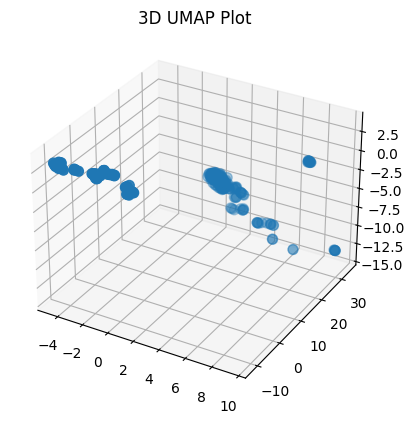

In [ ]:
# Plotting the 3D plot for the training data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], s=50)
ax.set_title('3D UMAP Plot')
plt.show()

**Data Analysis**

In [ ]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


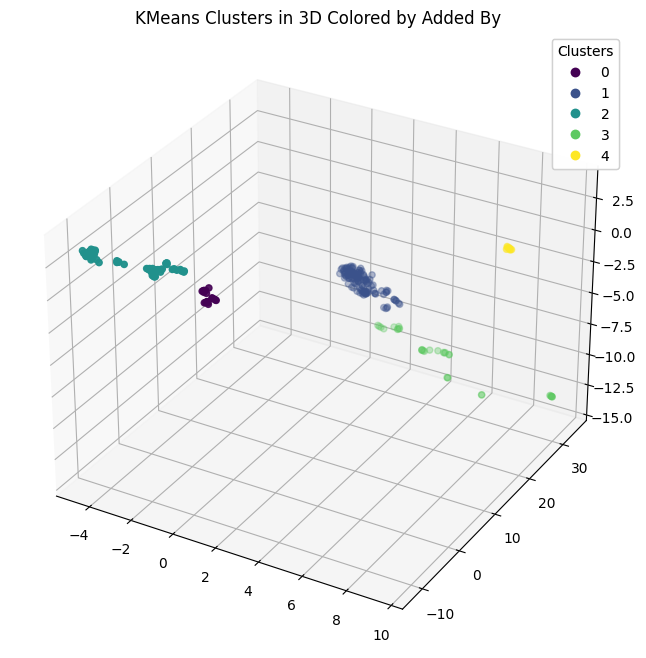

Cluster 0: Saad - 18.18%, Ibbi - 81.82%
Cluster 1: Saad - 66.40%, Ibbi - 33.60%
Cluster 2: Saad - 21.21%, Ibbi - 78.79%
Cluster 3: Saad - 59.38%, Ibbi - 40.62%
Cluster 4: Saad - 62.50%, Ibbi - 37.50%


In [ ]:
# Step 1: Apply KMeans Clustering on UMAP columns
kmeans = KMeans(n_clusters=5, random_state=0)  # Adjust the number of clusters if needed, UMAP is sensitive to changes in training data
train_df['Cluster'] = kmeans.fit_predict(train_df[['UMAP1', 'UMAP2', 'UMAP3']])

# Step 2: Plot the Clusters in 3D, colored by 'Added By'
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train_df['UMAP1'], train_df['UMAP2'], train_df['UMAP3'],
                     c=train_df['Cluster'], cmap='viridis', label=train_df['Added By'])
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('KMeans Clusters in 3D Colored by Added By')
plt.show()

# Step 3: Calculate and Print Percentages for Each Cluster
for i in range(kmeans.n_clusters):
    cluster_data = train_df[train_df['Cluster'] == i]
    total = len(cluster_data)
    saad_count = len(cluster_data[cluster_data['Added By'] == 'Saad'])
    ibbi_count = len(cluster_data[cluster_data['Added By'] == 'Ibbi'])
    saad_pct = (saad_count / total) * 100 if total > 0 else 0
    ibbi_pct = (ibbi_count / total) * 100 if total > 0 else 0
    print(f"Cluster {i}: Saad - {saad_pct:.2f}%, Ibbi - {ibbi_pct:.2f}%")

In [ ]:
# Print songs in each cluster
for i in range(kmeans.n_clusters):
    cluster_data = train_df[train_df['Cluster'] == i]
    print(f"Cluster {i}:")
    for j, row in cluster_data.iterrows():
        print(f"  - {row['Track Name']}")

Cluster 0:
  - Everlong - Acoustic Version
  - Stadium Arcadium
  - House Of Cards
  - High and Dry
  - 80's Comedown Machine
  - Morning Bell
  - Eternal Summer
  - Weird Fishes/ Arpeggi
  - Wet Sand
  - Swamp - 2005 Remaster
  - Present Tense
  - This Must Be the Place (Naive Melody) - 2005 Remaster
  - Everlong
  - Hearing Damage
  - Why Are Sundays So Depressing
  - Buddy Holly
  - Train in Vain (Stand by Me) - Remastered
  - Is This It
  - Ode To The Mets
  - The One I Love - Remastered 2012
  - Tap Out
  - Life During Wartime - 2005 Remaster
Cluster 1:
  - Idol Eyes
  - Sweat (A La La La La Long)
  - The Last Time
  - LivWithoutU
  - Pana-vision
  - Tudo Que Voce Podia Ser
  - The Trooper (Peaceful)
  - Capitalism
  - Head Over Heels - Dave Bascombe 7" N.Mix
  - Jackie Chan
  - Grace
  - when you sleep
  - We Don't Believe What's on TV
  - Here's Where the Story Ends
  - Preben Goes to Acapulco
  - Maybe
  - Summertime
  - Ebeneezer Goode - Beat Edit
  - Rip It Up
  - Kiss of Lif

0.5059288537549407


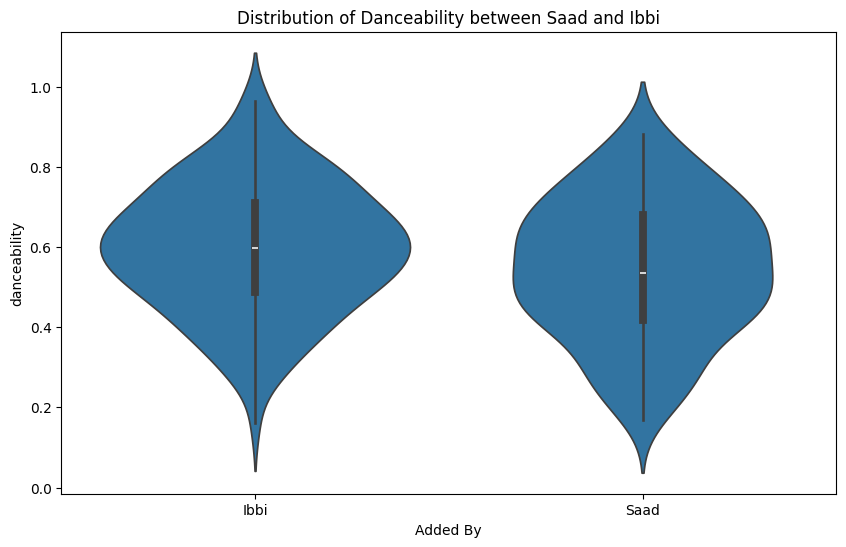

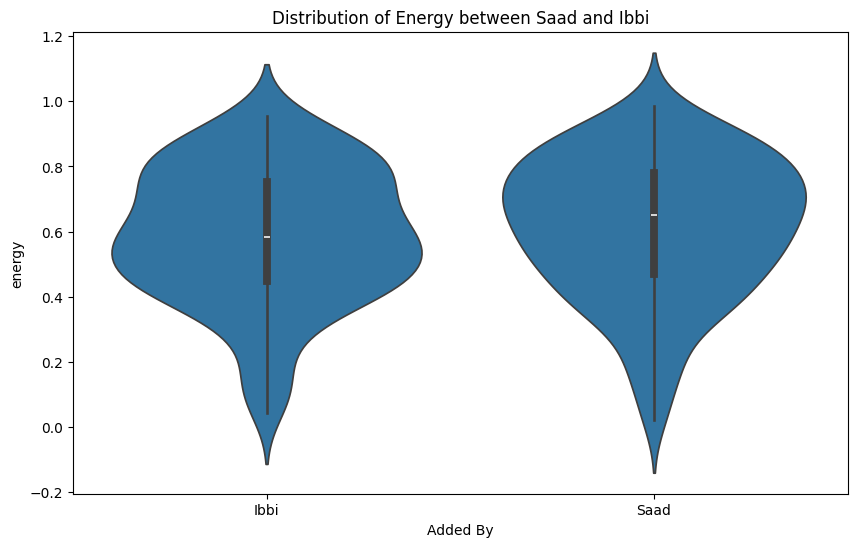

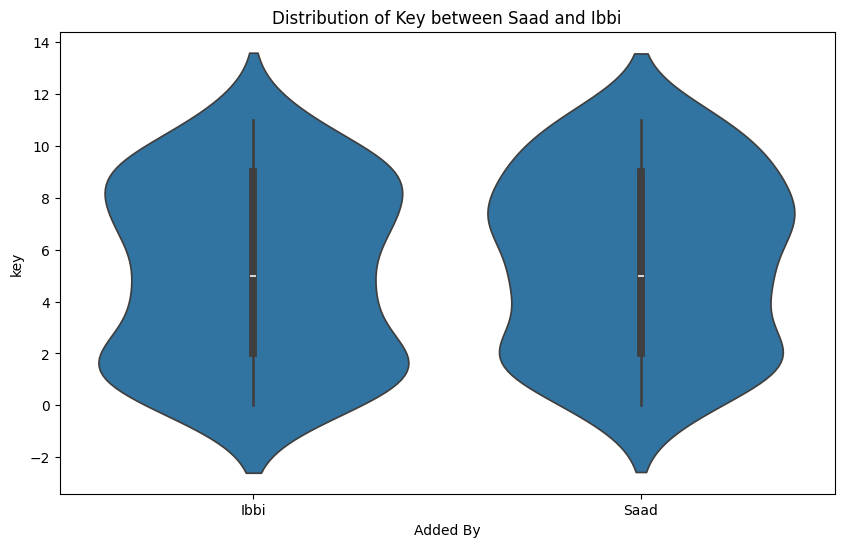

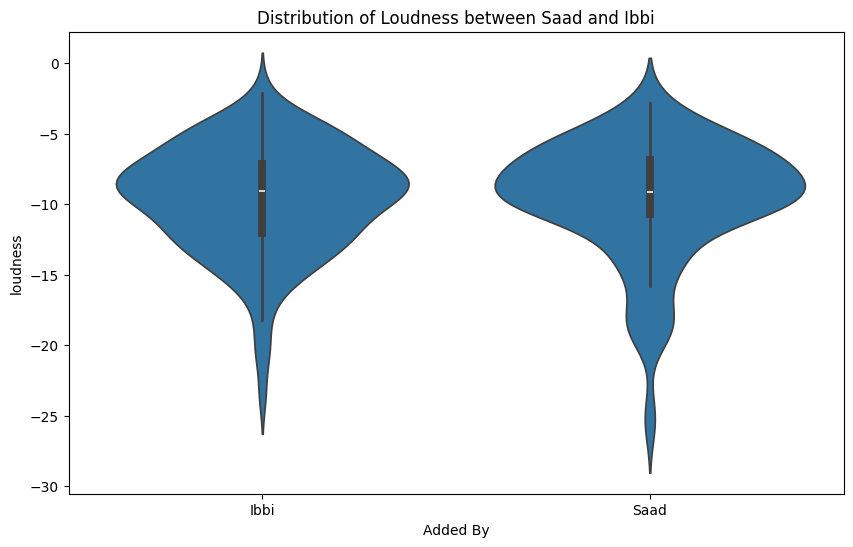

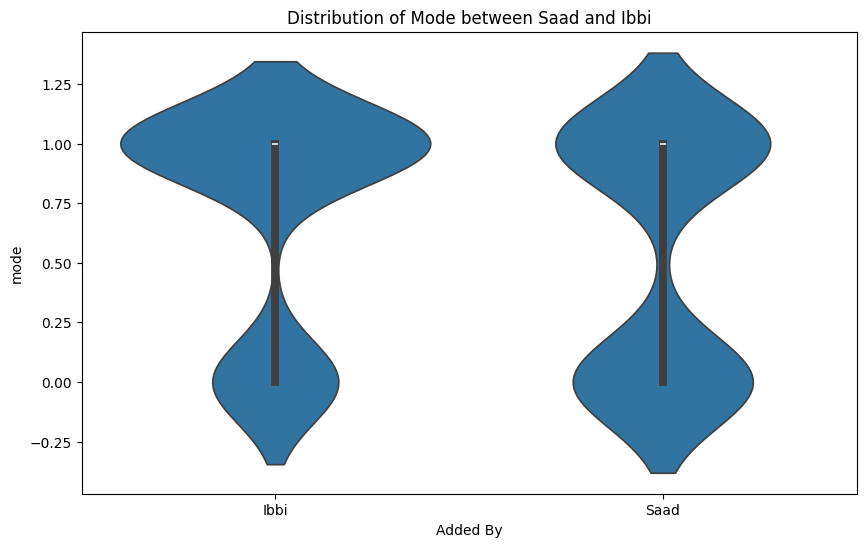

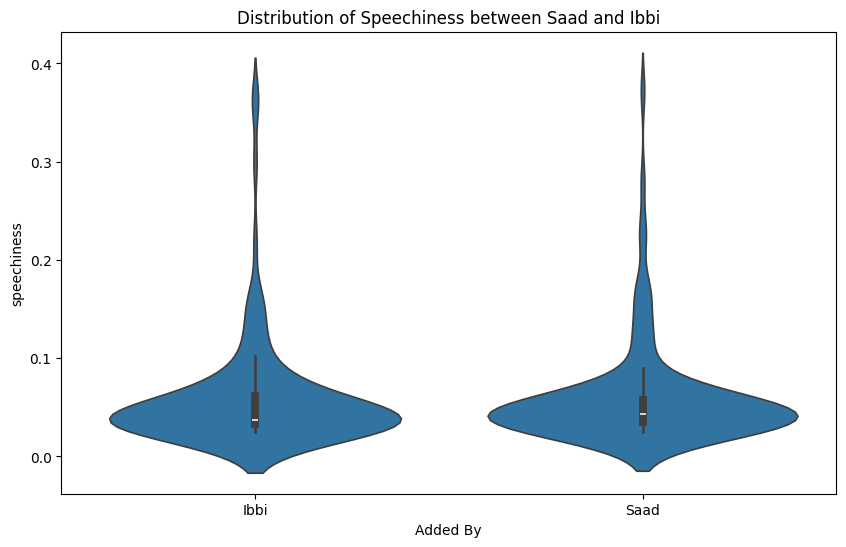

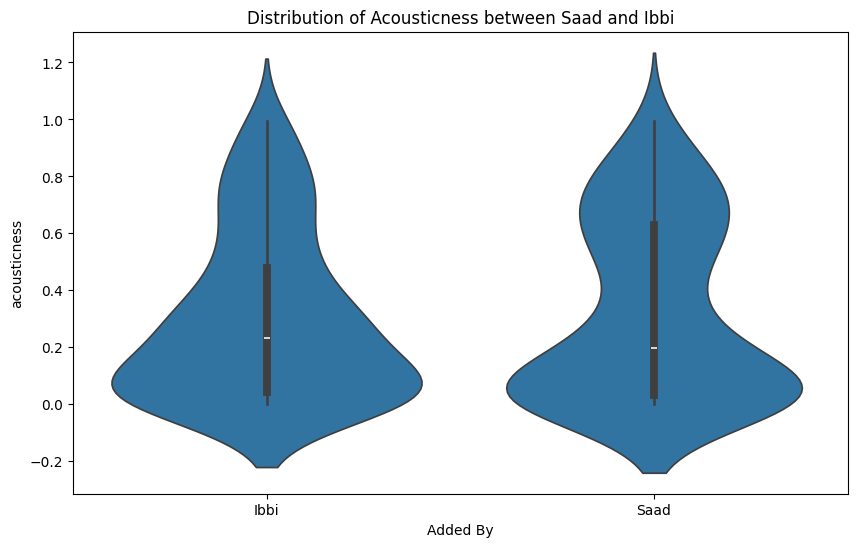

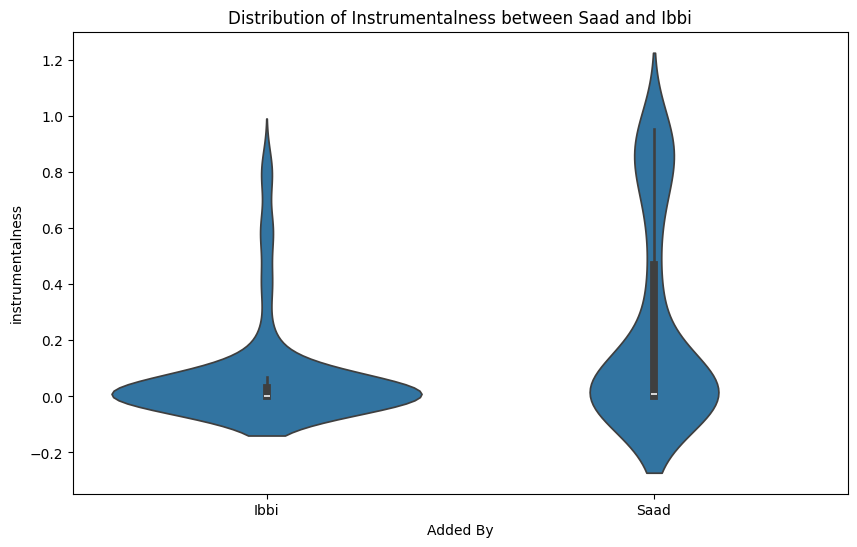

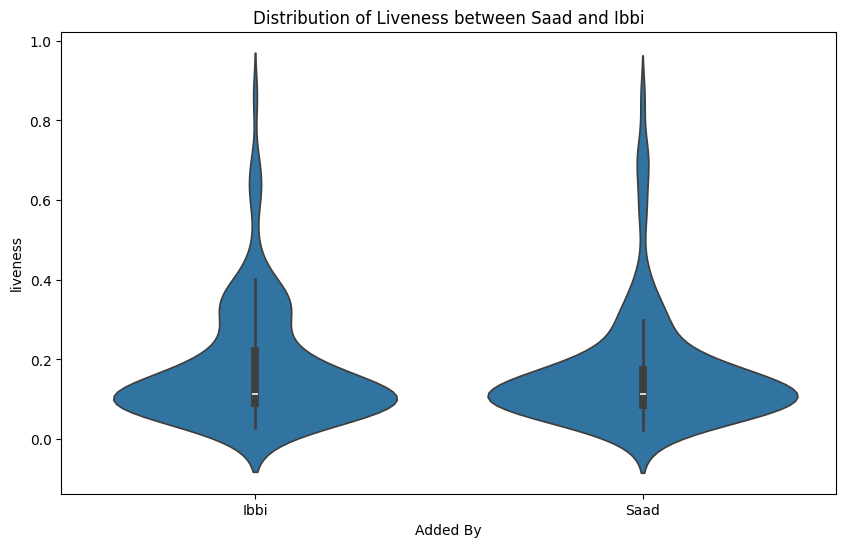

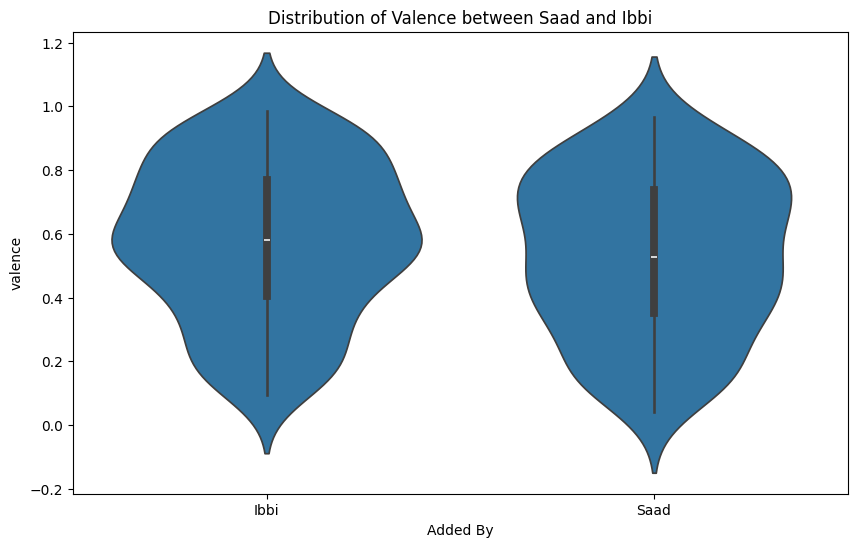

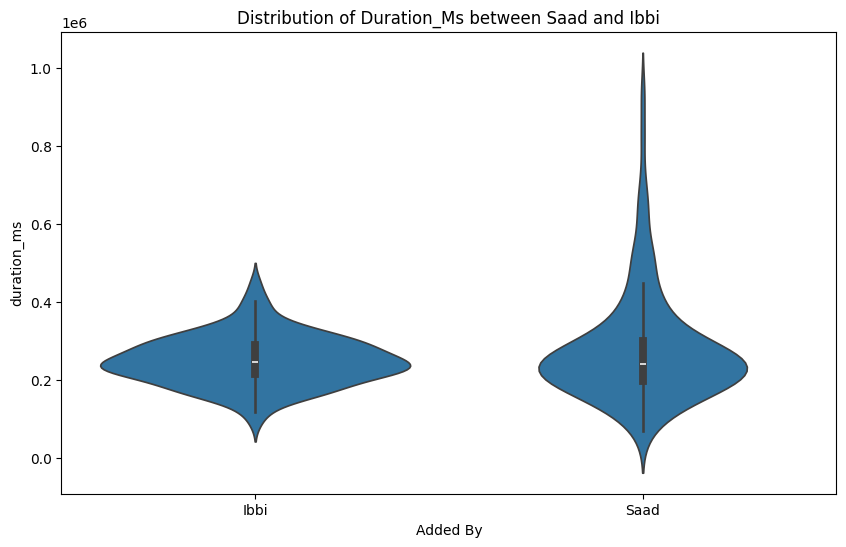

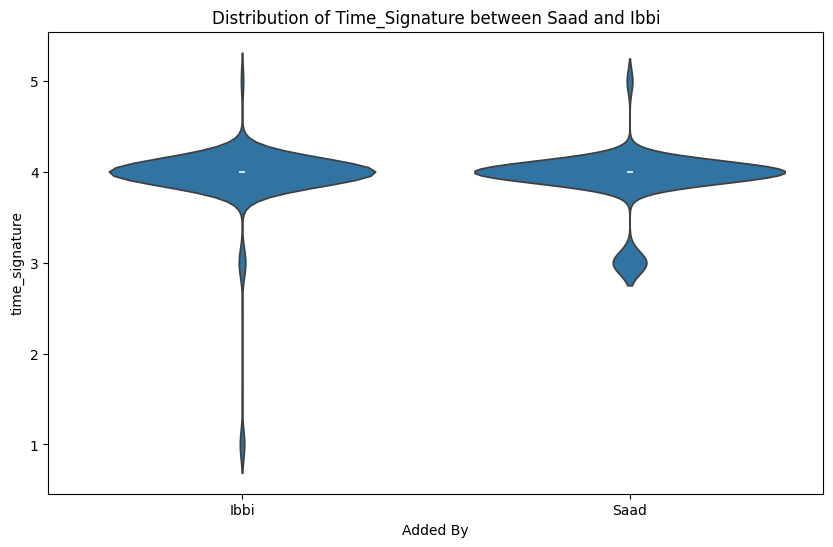

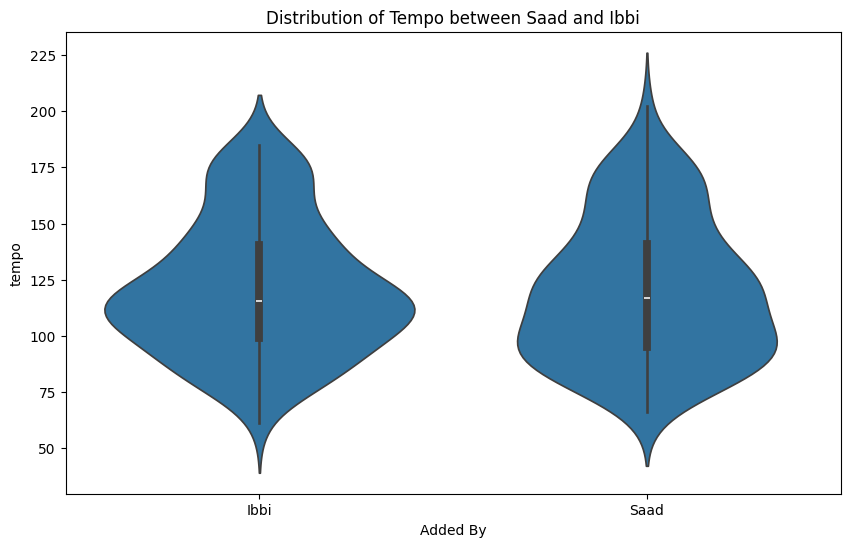

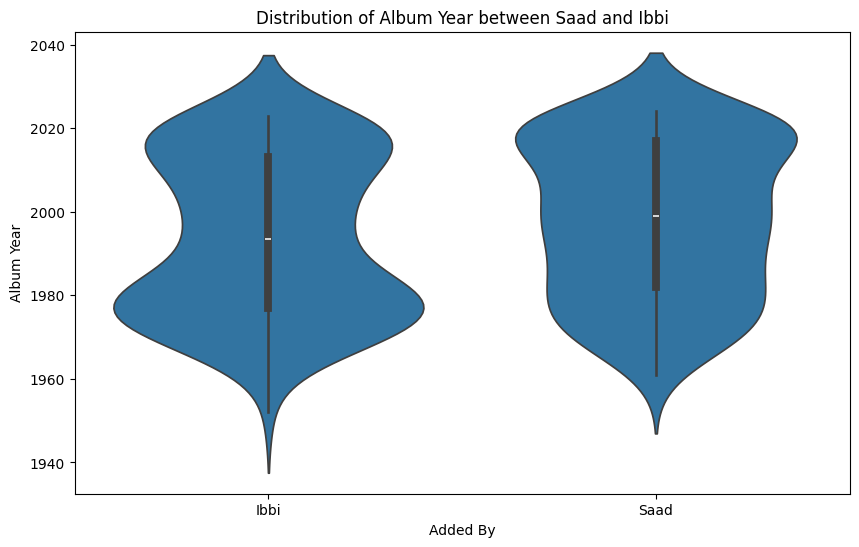

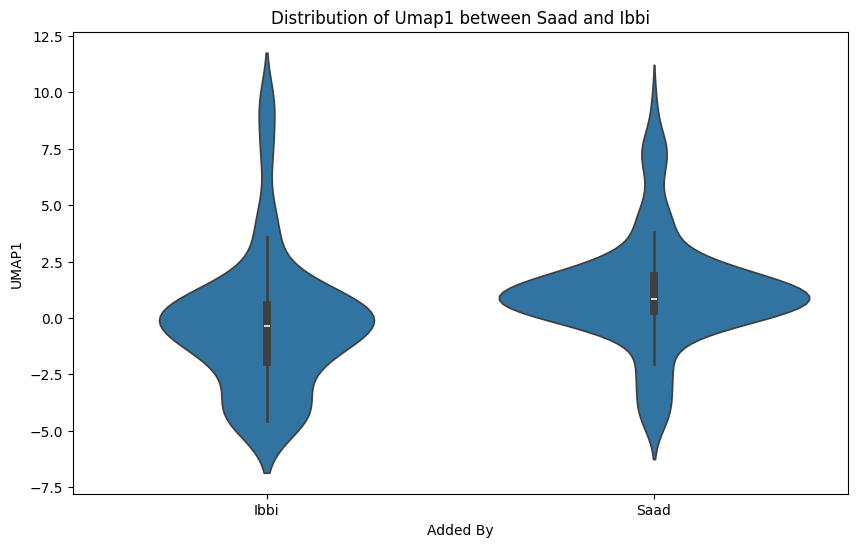

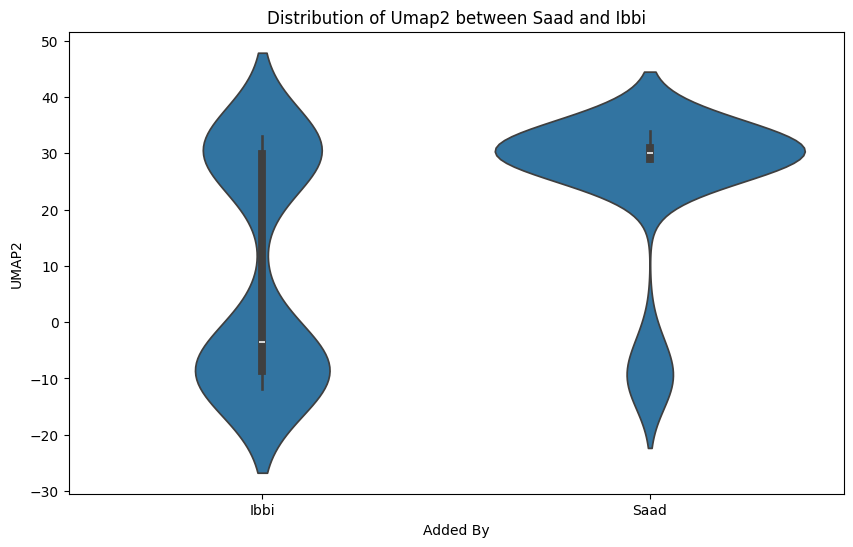

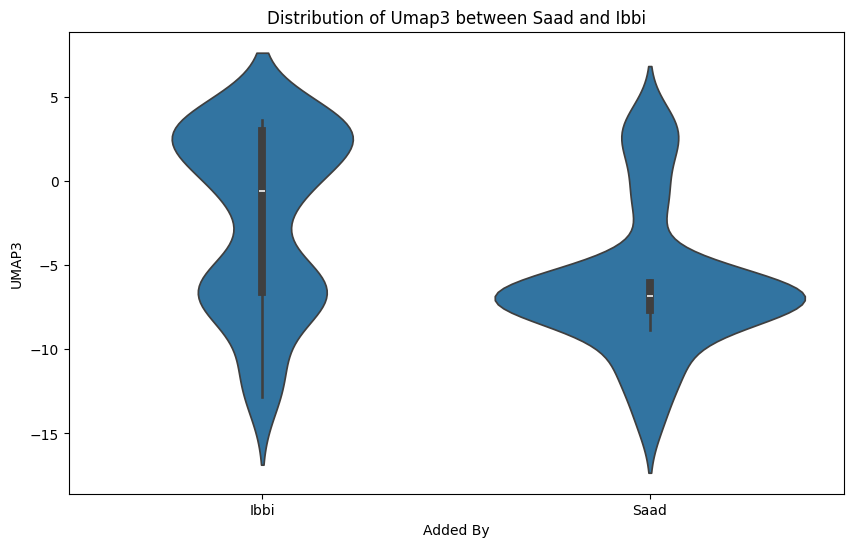

In [ ]:
# Drop the 'Cluster' column from the test dataframe
train_df.drop(columns=['Cluster'], inplace=True)

# Proportion of songs in the data are from:
ibbi_count = train_df[train_df['Added By'] == 'Ibbi'].shape[0]
saad_count = train_df[train_df['Added By'] == 'Saad'].shape[0]
total_count = ibbi_count + saad_count
print(ibbi_count/total_count)

# Splitting the DataFrame
tracks_saad = train_df[train_df['Added By'] == 'Saad']
tracks_ibbi = train_df[train_df['Added By'] == 'Ibbi']

# List of metrics to plot
metrics = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms', 'time_signature', 'tempo', 'Album Year', 'UMAP1', 'UMAP2', 'UMAP3']

# Create violin plots for each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Added By', y=metric, data=train_df)
    plt.title(f'Distribution of {metric.title()} between Saad and Ibbi')
    plt.show()

### **Part IV: ML Task**

In this project, we aim to explore whether abstract features provided by Spotify—such as tempo, song length, artist genre, etc.—can be used to build a machine learning model that predicts whether a song was added by myself or Ibbi. This endeavor seeks to gain insights into our musical preferences.

We will approach this as a straightforward binary classification task, where the dataset comprises entries labeled as 'Ibbi' or 'Saad.'

Before applying Uniform Manifold Approximation and Projection (UMAP) for dimensionality reduction, the dataset has been preemptively divided into training and test subsets. This precaution ensures that the UMAP transformation remains uninfluenced by the test data, thus preserving the integrity of our model's accuracy assessments.

### **Part V: Model Selection**

Random Forest is highly applicable for small datasets, such as those with 200+ data points, due to its ability to reduce variance and avoid overfitting. This ensemble method creates multiple decision trees on randomly selected data subsets and feature sets, leveraging the diversity among the trees to improve model accuracy and robustness. Aggregating predictions from various trees mitigates the impact of noise and outliers, reducing variance and making Random Forest a suitable choice for achieving reliable predictions in scenarios with limited data, as in this case.

Moreover, Random Forest's capability extends to classifying non-linear data, making it highly suitable for datasets exhibiting complex patterns, such as bimodal distributions and other anomalies identified in the data analysis above. Its ensemble approach allows it to capture non-linear relationships between features and outcomes effectively.

Gini Impurity is a critical metric in this model, serving as a measure of the likelihood that a randomly chosen element from a set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in that subset. It essentially quantifies the probability of misclassification and is mathematically defined as:

$$ Gini(S) = 1 - \sum_{i=1}^{C} (p_i)^2 $$

Here, \(S\) represents a set of samples, and \(p_i\) denotes the proportion of class \(i\) within \(S\). The formula calculates the Gini Impurity for any given set of samples, where a lower value indicates a more homogeneous node. We focus on Gini Impurity in our model is to ensure that each node in the tree is as informative as possible, thereby reducing information disorder. Thisa pproach to node splitting enhances the tree's ability to make accurate predictions, and is opted for as the criteria for our decision tree construction.

**Random Forest**

RandomForest(Dataset, n_trees, max_depth, min_samples_split, n_features):
1. Initialize an empty ensemble list for storing trees.
2. For i = 1 to n_trees:

   a. BootstrapSample = Randomly sample from Dataset with replacement.

   b. Tree = DecisionTree(BootstrapSample, max_depth, min_samples_split, n_features).

   c. Add Tree to ensemble.
   
3. Return ensemble.

DecisionTree(Dataset, max_depth, min_samples_split, n_features):
1. If stopping criteria met (max_depth or min_samples_split), return leaf with majority class.
2. BestSplit = None, LowestGini = 1.
3. For each feature in a random subset of size n_features:
   a. For each possible split value:

      i. Calculate Gini Impurity for the split.

      ii. If Gini < LowestGini:
          
          BestSplit = current split, LowestGini = Gini.

4. If BestSplit is None, return leaf.
5. LeftDataset, RightDataset = split Dataset based on BestSplit.
6. LeftChild = DecisionTree(LeftDataset, max_depth - 1, min_samples_split, n_features).
7. RightChild = DecisionTree(RightDataset, max_depth - 1, min_samples_split, n_features).
8. Return node with BestSplit, LeftChild, RightChild.

Predict(Ensemble, Sample):
1. Votes = [Tree.predict(Sample) for Tree in Ensemble].
2. Return majority class from Votes.

### **Part VI: Model Training**

  The model was training and optimized for hyperparameters.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Features and target definition
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness',
            'duration_ms', 'Album Year', 'UMAP1', 'UMAP2', 'UMAP3']

"""
In case of comparison for not incorporating genre information:

features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness',
            'duration_ms', 'Album Year']

"""

X = train_df[features]
y = train_df['Added By']

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit and transform X

# Hyperparameter grid
# Running the code across the entire param grid will be more time consuming that it already if so I cut it down a bit by using values I found worked
param_grid = {
    'n_estimators': [300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini'],
    'max_features': ['auto']
}


# Initialize the Random Forest Classifier
model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_scaled, y)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best score from the grid search (mean cross-validated score of the best_estimator)
print("Best Grid Search Score:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best Grid Search Score: 0.756078431372549


### **Part VII: Model Performance**

The model demonstrates good performance, underlined by high accuracy and f1 scores. The significant jump in model accuracy from approximately 60% after incorporating UMAP genre data shows its strong predictive power.

Given the small dataset size, fluctuations in the train-test split have led to instances where test accuracy surpasses training accuracy. However, this phenomenon is inconsistent across different random state splits, indicating that such overperformance on test data is due to the specific data partitioning.

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, auc

In [ ]:
X_test = test_df[features]
y_test = test_df['Added By']

# Standardize the test data features using the previously fitted scaler
X_test_scaled = scaler.transform(X_test)

# Using the best model to predict the target variable on the test data
y_pred = grid_search.best_estimator_.predict(X_test_scaled)

In [ ]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred, target_names=['Ibbi', 'Saad'])

print(report)

Accuracy on test data: 0.6470588235294118
              precision    recall  f1-score   support

        Ibbi       0.59      0.88      0.71        41
        Saad       0.79      0.43      0.56        44

    accuracy                           0.65        85
   macro avg       0.69      0.65      0.63        85
weighted avg       0.69      0.65      0.63        85



In [ ]:
# Create a DataFrame with song names, actual labels, and predicted labels
results_df = pd.DataFrame({
    'Song Name': test_df['Track Name'],
    'Actual Label': y_test,
    'Predicted Label': y_pred
})

# Randomly select 20 rows from the results DataFrame
random_results = results_df.sample(n=20, random_state=42)  # Use a fixed random state for reproducibility

# Print the randomly selected song names with their actual and predicted labels
print(random_results)

                                      Song Name Actual Label Predicted Label
78                                         ブリーズ         Saad            Saad
0                      Disorder - 2007 Remaster         Saad            Saad
68                                  How Bizarre         Saad            Ibbi
22                               Skankin' Sweet         Ibbi            Ibbi
12                                     Velocity         Saad            Saad
82            Down by the River - 2009 Remaster         Saad            Saad
10                   Only A Fool Would Say That         Saad            Ibbi
18                             Meeting Waterboy         Saad            Saad
4                                     Limelight         Ibbi            Ibbi
66                                      Al-Vida         Saad            Ibbi
40                  St. Stephen - 2015 Remaster         Saad            Saad
47                                       Lament         Saad            Ibbi

### **Part VIII: Results & Discussion**

The model is better at correctly classifying 'Ibbi' songs than 'Saad' songs, but it must also be corrected by misclassifying 'Saad' songs as 'Ibbi.' A high area under the curve (AUC) of 0.83 suggests that the model has a good separability measure, indicating that it can distinguish between the classes well. The random variations in the curve indicate that the model's performance is inconsistent across different thresholds, which could be due to the small size of the test dataset leading to a less smooth curve.

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, auc
import matplotlib.pyplot as plt
import seaborn as sns

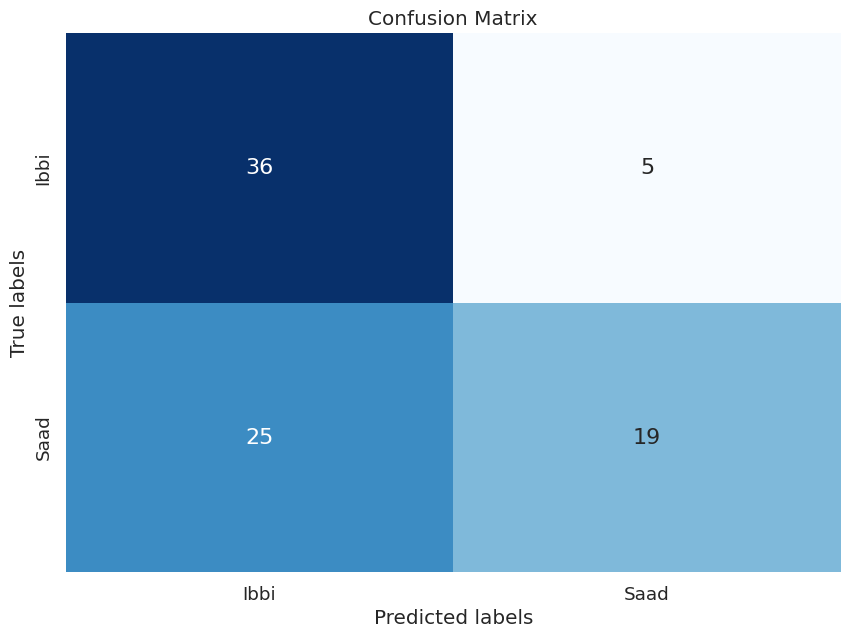

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualization
plt.figure(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(['Ibbi', 'Saad'])
ax.set_yticklabels(['Ibbi', 'Saad'])
plt.show()

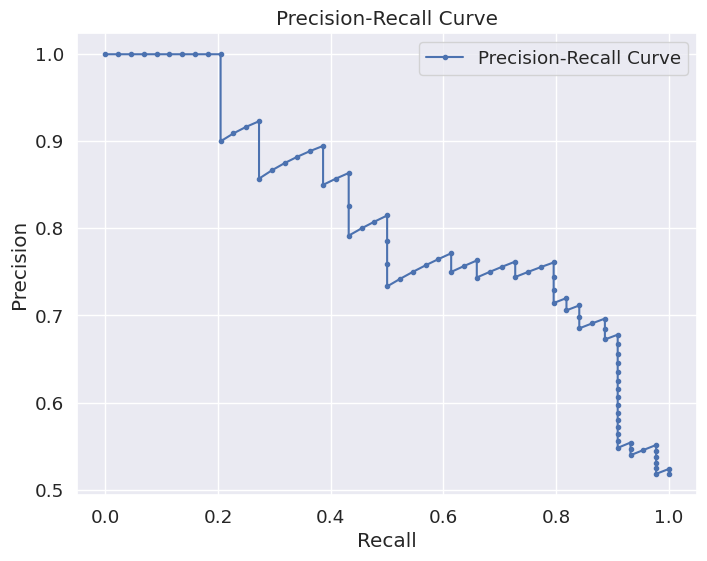

Area Under Precision-Recall Curve: 0.81


In [ ]:
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Convert string labels to binary
y_test_binary = y_test.map({'Saad': 1, 'Ibbi': 0})

# Now, you can calculate precision and recall values using the binary labels
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_pred_proba)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Calculate the area under the precision-recall curve
auc_precision_recall = auc(recall, precision)
print(f"Area Under Precision-Recall Curve: {auc_precision_recall:.2f}")

### **Part IX: Summary**

1. API --> Playlist Data
2. API --> Liked Songs Data

3. Playlist Data + Liked Songs Data --> Total Songs Data

4. API + Total Songs Data --> Year Data
5. API + Total Songs Data --> Genre Data

6. UMAP(Genre Data) --> Processed Genre Data

7. Year Data + Processed Genre Data + Total Songs Data --> Final Combined Data

8. Final Combined Data -- Train/Test Split --> Training Data + Testing Data

9. Training Data --> [Random Forest Model Training]
10. Testing Data --> [Model Evaluation]

My experience revealed the importance of exploring methods beyond those covered in class, such as UMAP over PCA, to identify unique characteristics of the data that may make alternative approaches more fitting. Comparing various models and ultimately selecting the random forest for its performance demonstrated that, during data availability constraints, a relatively straightforward method can still yield a highly effective model.

The model's performance can be enhanced and irregularities reduced by increasing the volume of training data, evaluating alternative test-train splits such as 70-30, which may still provide a robust training set for the random forest algorithm, and incorporating additional features like lyrics. In contrast, a more rigorous feature selection process could help reduce overfitting.

### **Part X: References**

“Web Api.” Web API | Spotify for Developers, developer.spotify.com/documentation/web-api. Accessed 17 Feb. 2024.

“Uniform Manifold Approximation and Projection for Dimension Reduction.” UMAP, umap-learn.readthedocs.io/en/latest/. Accessed 17 Feb. 2024.

# **Pipeline II**

### **Part I: Data Collection**

How do you squeeze a lemon with no juice?

That's the technical challenge I've endeavored to solve. For a somewhat small dataset that showcases minimal differences between two classes, the solution lies in employing a more efficient 'lemon-squeezer'—utilizing more robust models, introducing new features such as Lyrics data, and better feature extraction.

I chose not to employ data augmentation as, despite the dataset's relatively abundant features compared to its size, using XGBoost with regularization has resulted in K-fold scores that vary within a reasonable range of 10%. This variation suggests a balanced performance, yet I'm open to exploring data augmentation in future pipelines to enhance the volume and variety of lyrics data at my disposal.

The lyrics data was sourced through the MusicMatch API, the sole free lyrics API I discovered, which provides access to 30% of the lyrics for any given song. I aimed to assess whether including lyrics data, alongside other features and metadata such as the number of characters in the lyrics, would amplify the model's predictive capabilities.

The code to fetch this data is in Pipeline I, including requests to the Spotify API. An additional modification in the first pipeline involved creating a "Type" column for train-test splits. This is crucial for applying dimensionality reduction techniques effectively; it ensures that the model is trained solely on training data and can be used for both training and test data without the risk of cross-contamination. Such contamination could occur if the model were deployed externally, where it would encounter new data. The introduction of a separate "Type" column allows for the direct reshuffling of labels in the second pipeline as needed without revisiting the train-test split established in the first.

(This Pipeline can be found as a Google Colab notebook [here](https://colab.research.google.com/drive/10PgOgP1Gv3AYvgJZZaJyo7fOCoyLQXBi?usp=sharing))

### **Part II: Loading Data**

To ensure efficiency and adhere to the usage limits of the Spotify API, it is advisable to avoid running the entire pipeline to update song data. Given the stringent monthly API call restrictions associated with both utilized APIs, a more resourceful approach involves retrieving the necessary data directly from a designated [GitHub repository](https://github.com/MSaadAsad/CS156-Pipeline). This method circumvents potential time constraints and optimizes the use of available API calls.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
text_data = pd.read_csv("https://github.com/MSaadAsad/CS156-Pipeline/blob/d96b8815c6e7f88e561f405242d5dec3fd636816/tracks.csv")

### **Part III: Data Cleaning**

I conduct a random train-test division, subsequently leveraging this split to create new UMAP compressions for the genre encodings (Genre Vectors), ensuring the compression model remains uninformed about the test dataset.

UMAP, previously discussed, will be revisited as a method for dimensionality reduction.

The train-test split is randomized to ensure diversity. Additionally, preprocessing steps are implemented to filter out non-lyrical content received from the API, potentially contaminating the dataset. This preprocessing includes calculating a "Has Lyrics" column to quantify the lyrical content present in each song.

In [ ]:
import pandas as pd
from gensim import corpora, models
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Calculate the number of samples to designate as 'test'
num_test_samples = int(len(text_data) * 0.25)

# Generate random indices without replacement
test_indices = np.random.choice(text_data.index, size=num_test_samples, replace=False)

# Initially set all to 'train' or your default type
text_data['Type'] = 'train'

# Set approximately 25% of the entries to 'test' based on the randomly chosen indices
text_data.loc[test_indices, 'Type'] = 'test'

In [ ]:
genre_vectors_arrays = [np.array([float(num) for num in vec.strip("[]").split()]) for vec in text_data["GenreVectors"]]

In [ ]:
text_data["GenreVectors"] = genre_vectors_arrays

In [ ]:
# Split the DataFrame into training and test sets based on the 'Type' column.
train_df = text_data[text_data['Type'] == 'train']
test_df = text_data[text_data['Type'] == 'test']

# Convert Genre Vectors of the training data to a numpy array for UMAP processing.
train_genre_vectors = np.stack(train_df["GenreVectors"].values)

# Initialize the UMAP embedder with 3 components for dimensionality reduction and fit it on the training data only.
embedder = UMAP(n_components=3)
embedder.fit(train_genre_vectors)

# Transform the training data genre vectors into a lower-dimensional space using UMAP.
train_embedding = embedder.transform(train_genre_vectors)

# Create a DataFrame from the UMAP transformed data and name the columns accordingly.
train_summed_genres = pd.DataFrame(train_embedding, columns=['UMAP1', 'UMAP2', 'UMAP3'])

# Concatenate the UMAP features back to the original training DataFrame and reset the index to avoid duplication.
train_df = pd.concat([train_df.reset_index(drop=True), train_summed_genres], axis=1)

# Repeat the process for test data.
test_genre_vectors = np.stack(test_df["GenreVectors"].values)
test_embedding = embedder.transform(test_genre_vectors)
test_summed_genres = pd.DataFrame(test_embedding, columns=['UMAP1', 'UMAP2', 'UMAP3'])
test_df = pd.concat([test_df.reset_index(drop=True), test_summed_genres], axis=1)

# Combine the training and test DataFrames back into a single DataFrame for further analysis and reset the index.
text_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [ ]:
# Replace missing values in 'Lyrics' with empty strings
text_data['Lyrics'] = text_data['Lyrics'].fillna('')

# Add a new column indicating the length of lyrics
text_data['Has Lyrics'] = text_data['Lyrics'].apply(lambda x: len(x))

# Remove disclaimers from 'Lyrics' and trim whitespace
text_data['Lyrics'] = text_data['Lyrics'].str.replace(r"\*\*\*\*\*\*\* This Lyrics is NOT for Commercial use \*\*\*\*\*\*\*.*", "", regex=True).str.strip()
text_data['Lyrics'] = text_data['Lyrics'].str.replace(r"\d{5,}", "", regex=True).str.strip()

**TD-IDF / LDA**

Employing TF-IDF (Term Frequency-Inverse Document Frequency) to analyze topics within song lyrics enables identifying and quantifying pivotal words, highlighting their significance. This analysis initiates with the setup of a TF-IDF Vectorizer, designed to omit shorter, less informative words by employing a specialized token pattern. Focusing on longer words, the method filters out commonplace yet trivial language, directing attention to terms with potential thematic depth.

The transformation of the 'Lyrics' column into a TF-IDF feature matrix provides a numerical representation of each song based on the relative significance of words within it while adjusting for their prevalence across the entire song collection. Normalizing these values ensures that differences in song length or word frequency don't distort the analysis.

This normalized matrix is then converted into a data frame, which aids in grouping songs by their contributor. This step allows for the computation of average TF-IDF scores for each word by group, highlighting the most distinctive words that reflect the lyric choices. However, the words in isolation may not provide complete clarity.

The analysis progresses with LDA (Latent Dirichlet Allocation) to delve into the thematic variances in the selected lyrics. This process also starts with eliminating common stop words and excluding shorter words through tokenization. Organizing the lyrics into contributor-specific groups facilitates a focused examination of each group's thematic essence. A dictionary of terms is compiled for each group, forming a corpus that depicts the collection of lyrics in a bag-of-words model. This corpus is then subjected to LDA, which discerns topics within the text by grouping words that tend to appear together, thus unveiling the core themes.

According to the findings, Ibbi's songs predominantly explore themes of Reflection, Resilience, and Yearning, whereas the themes in my songs gravitate towards Longing, Creation, and Awareness. These characterizations, as described by GPT [here](https://chat.openai.com/share/e/662bb268-1d7d-475a-8675-7448ef4e67f4), delve into further specifics. Are these characterizations accurate?... I'd avoid commenting.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

In [ ]:
# Set up TF-IDF Vectorizer, ignoring short words
tfidf_vectorizer = TfidfVectorizer(max_features=3586, stop_words='english', token_pattern=r'\b\w{4,}\b')

# Generate TF-IDF matrix for 'Lyrics'
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data['Lyrics'])

# Apply row-wise normalization to TF-IDF values
tfidf_matrix_norm = normalize(tfidf_matrix, norm='l1', axis=1)

# Convert normalized TF-IDF matrix to DataFrame, naming columns after words
tfidf_df = pd.DataFrame(tfidf_matrix_norm.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Merge contributor info into TF-IDF DataFrame
tfidf_df['Added By'] = text_data['Added By']

# Compute mean TF-IDF scores per contributor
avg_tfidf_by_contributor = tfidf_df.groupby('Added By').mean()

# Identify and display top 10 words per contributor by average TF-IDF score
top_words_by_contributor = avg_tfidf_by_contributor.T.apply(lambda x: x.nlargest(10).index.tolist())
print(top_words_by_contributor)

Added By   Ibbi       Saad
0          know      light
1          love       like
2          just  dragonfly
3          yeah       away
4          like       love
5          time     zombie
6          want       just
7          stay       come
8         cause       make
9          baby       yeah


In [ ]:
# Filter out common words and short words from lyrics
stop_words = set(stopwords.words('english'))

# Tokenize 'Lyrics' with custom conditions
text_data['tokenized_lyrics'] = text_data['Lyrics'].apply(
    lambda x: [word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words and len(word) > 3]
)

# Group data by contributor
grouped_text_data = text_data.groupby('Added By')

for name, group in grouped_text_data:
    print(f"Topics for '{name}':")

    # Prepare texts for topic modeling
    dictionary = corpora.Dictionary(group['tokenized_lyrics'])
    dictionary.filter_extremes(no_below=10, no_above=0.7)

    # Build corpus from tokenized lyrics
    corpus = [dictionary.doc2bow(text) for text in group['tokenized_lyrics']]

    # Perform LDA analysis
    lda_model = models.LdaModel(
        corpus,
        num_topics=10,
        id2word=dictionary,
        passes=20,
        alpha='auto',
        eta='auto'
    )

    # Print identified topics
    topics = lda_model.print_topics(num_words=5)
    for topic in topics:
        print(topic)

    # Separator for clarity
    print("\n" + "-"*50 + "\n")

Topics for 'Ibbi':
(0, '0.196*"every" + 0.095*"baby" + 0.075*"night" + 0.074*"take" + 0.048*"could"')
(1, '0.242*"still" + 0.110*"need" + 0.094*"little" + 0.086*"give" + 0.082*"come"')
(2, '0.116*"baby" + 0.084*"good" + 0.079*"never" + 0.074*"time" + 0.069*"said"')
(3, '0.231*"feel" + 0.086*"many" + 0.082*"tell" + 0.063*"back" + 0.060*"well"')
(4, '0.143*"like" + 0.135*"love" + 0.099*"yeah" + 0.065*"come" + 0.059*"right"')
(5, '0.131*"time" + 0.106*"back" + 0.093*"well" + 0.075*"summer" + 0.073*"things"')
(6, '0.157*"love" + 0.076*"want" + 0.073*"would" + 0.060*"call" + 0.053*"without"')
(7, '0.207*"stay" + 0.141*"yeah" + 0.075*"dream" + 0.065*"could" + 0.042*"like"')
(8, '0.211*"know" + 0.110*"like" + 0.092*"want" + 0.076*"yeah" + 0.042*"think"')
(9, '0.147*"long" + 0.124*"eyes" + 0.123*"away" + 0.056*"heart" + 0.051*"think"')

--------------------------------------------------

Topics for 'Saad':
(0, '0.482*"know" + 0.107*"mind" + 0.103*"hold" + 0.093*"much" + 0.088*"feel"')
(1, '0.6

**BERT Embeddings**

For the text analysis, we have to find a richer representation of them than simply tf-idf weighting of words since that does not reflect more complex relations in their meanings. So, instead, we generate word embeddings, which are high-dimensional vectors reflecting the semantic similarity of words by grouping closer words that co-occur in similar situations (e.g., cat and dog). This is inspired by an implementation by [Ke et al.](https://slolla.github.io/files/nlp.pdf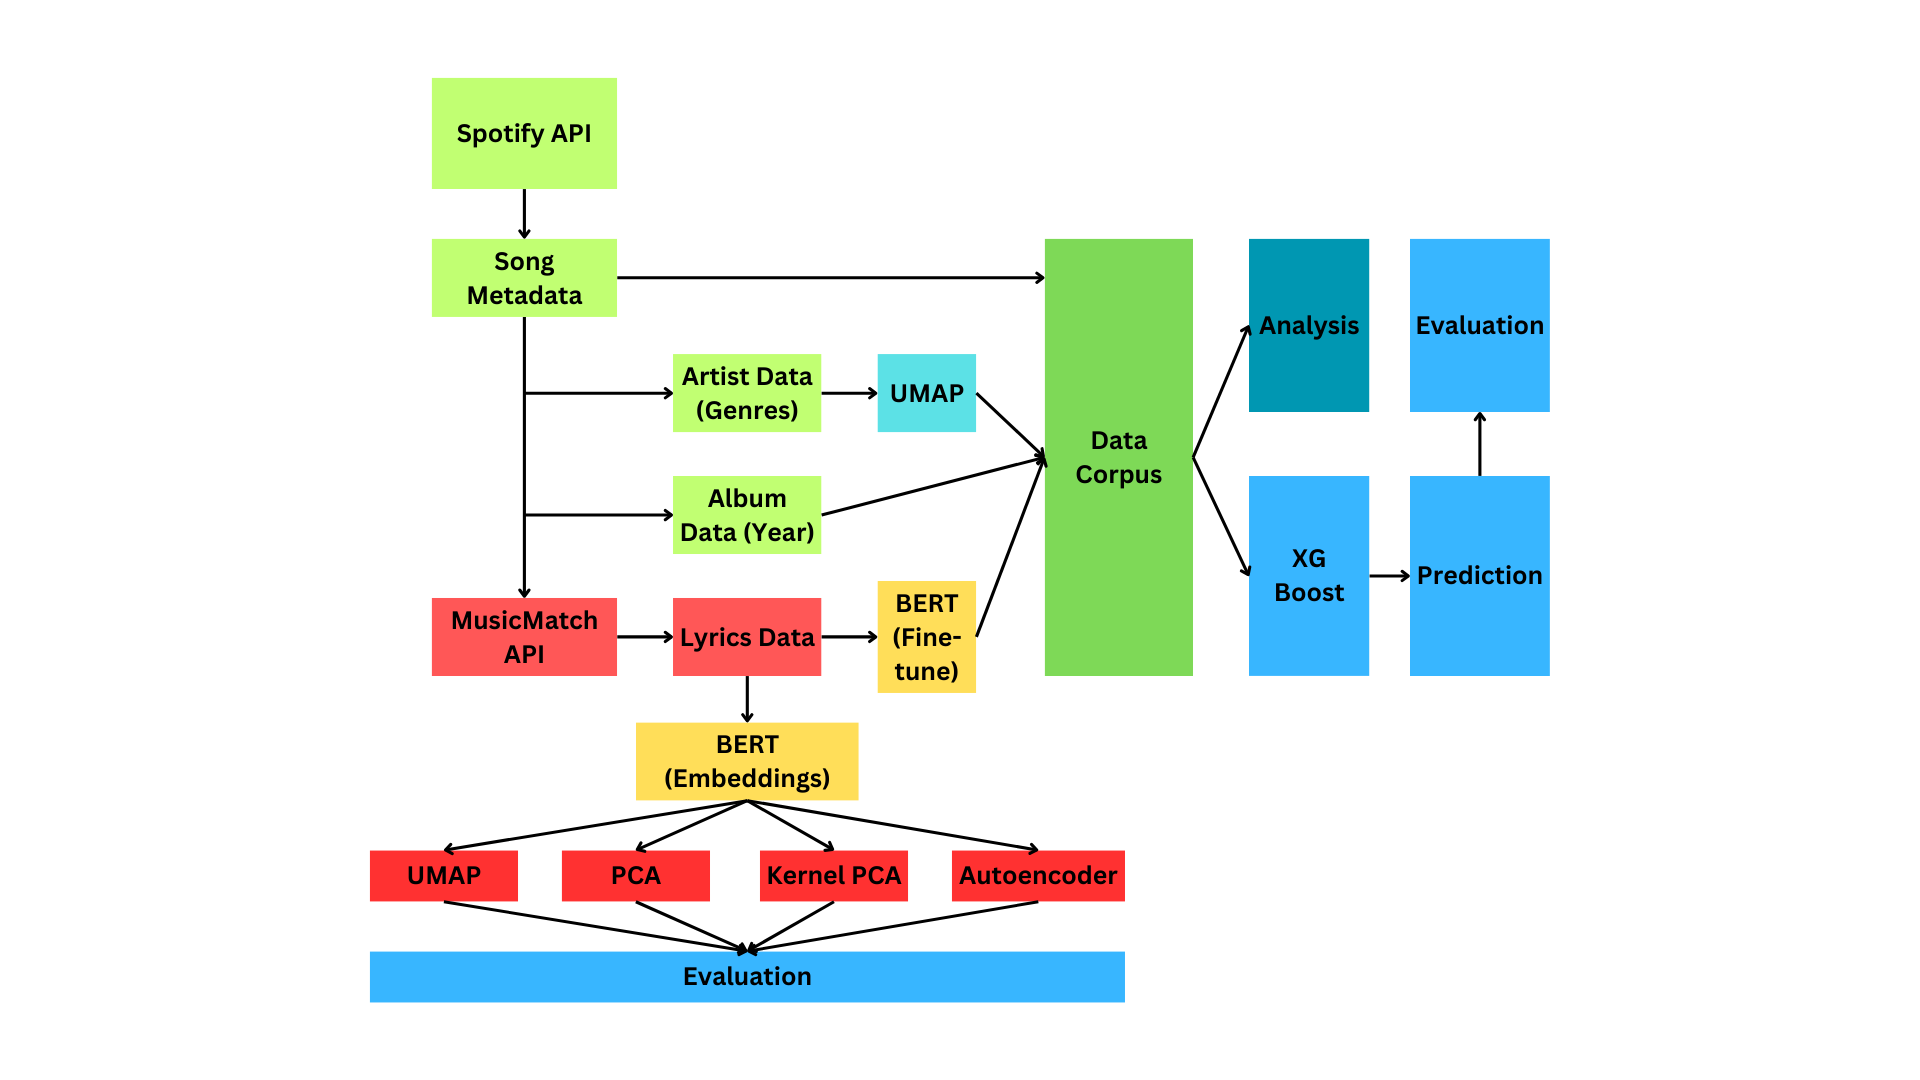), who similarly used song lyric embeddings from BERT to predict Spotify metadata. More specifically, we use BERT for embedding generation, which has the added advantage of attention - that rather than a set context window around the keyword, we can focus on more distant text sections relevant to the current word. Being bidirectional, this applies to both directions of the words and also incorporates the token type (e.g., noun vs. verb).

Here, we use DistilBERT, a more lightweight version of BERT that is lighter to use while not compromising heavily on model performance. We first tokenize the words and then embed them. I defined a function I used to tweak the embedding layer we wanted to use. I also compared using average pooling and max pooling of the generated embeddings for each document since each document has a 512-dimension vector per token and multiple tokens per document (each song). This was done by seeing how it impacted downstream model performance. Either way, this is very lossy to the data information as we convert all tokens to a single representation.

In [ ]:
pip install transformers

In [ ]:
from transformers import DistilBertModel, DistilBertTokenizer
import torch
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Initialize the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
lyrics = text_data["Lyrics"].to_list()

In [ ]:
def get_distilbert_embedding(text, use_max_pooling=True, layer_index=-1):
    """
    Computes embeddings for text using the DistilBERT model.

    Parameters:
    - text (str): The text to be encoded into embeddings.
    - use_max_pooling (bool): If True, uses max pooling to aggregate token embeddings; otherwise, uses mean pooling.
    - layer_index (int): Specifies the DistilBERT model layer from which to extract embeddings. The default (-1) is the last layer.

    Returns:
    - A numpy array of the calculated embeddings.
    """
    # Prepare text for the model
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Model inference to get hidden states without updating weights
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # Extract embeddings from the specified layer
    layer_embeddings = outputs.hidden_states[layer_index]

    if use_max_pooling:
        # Max pooling: get the highest value across each dimension of the token embeddings
        embeddings = torch.max(layer_embeddings, dim=1).values.squeeze().numpy()
    else:
        # Mean pooling: calculate the average across token embeddings
        embeddings = layer_embeddings.mean(dim=1).squeeze().numpy()

    return embeddings

layer_index = -2  # Selecting the second-to-last layer
embeddings = [get_distilbert_embedding(lyric, use_max_pooling=False, layer_index=layer_index) for lyric in lyrics]

In [ ]:
text_data['Embeddings'] = embeddings

### **Part IV: ML Task**

Once again, we aim to perform binary classification on songs I added versus those added by Ibbi, with an additional focus on lyrics data. Given that we can't efficiently process 512-dimensional embedding inputs, we aim to employ dimensionality reduction techniques to compress these embeddings to a more manageable size of three visualizable dimensions.

This will also allow us to compare various dimensionality reduction techniques. In particular, I've noted substantial information on [UMAP](https://arxiv.org/pdf/1802.03426.pdf) as a [visualization tool](https://medium.com/aimonks/a-comparative-analysis-of-dimensionality-reduction-techniques-in-machine-learning-3389c5103348) over the six years since its introduction. Its underuse in machine learning pipelines is surprising, especially considering its effectiveness with my non-linear sparse data in a previous pipeline. However, this effectiveness could be specific to that dataset. Furthermore, it's worth exploring in future analyses whether specific hyperparameters—given UMAP's sensitivity in clustering—might be more conducive to machine learning pipelines. This could potentially be a topic for a Medium article, as an offshoot of this assignment.

**UMAP Technical Description**

UMAP is a dimensionality reduction technique that approximates a manifold by constructing a high-dimensional graph of the data points and then optimizing a low-dimensional projection of the graph's datapoints to be as structurally similar as possible to each other's relative positions in the high-dimensional space. The low-dimensional graph aims to preserve these structures through a gradient descent.

**Pseudocode**

1. **Construct high-dimensional graph**: For each point, compute the distance to its $k$ nearest neighbors.
2. **Convert distances to probabilities**: Apply a Gaussian kernel to transform distances into probabilities, emphasizing closer points. These probabilities are used to randomly move certain points closer to each other in the lower dimensional space.
3. **Optimize embedding**: Use gradient descent to minimize the cross-entropy between the high-dimensional and low-dimensional graphs, preserving topological features.

- **Gaussian Kernel**: $P(i|j) = \exp\left(-\frac{{\|x_i - x_j\|^2}}{{2\sigma^2}}\right)$, for adjusting the edge weights in the high-dimensional graph.
- **Cross-Entropy Minimization**: $\mathcal{L} = \sum_{i, j} p_{ij} \log\left(\frac{p_{ij}}{q_{ij}}\right)$, where $p_{ij}$ and $q_{ij}$ represent probabilities in high-dimensional and low-dimensional spaces, respectively, guiding the optimization. Cross-entropy essentially measures how well the lower-dimensional space can represent the higher-dimensional one.


### **Part V: Model Selection**

**Dimensionality Reduction Analysis**

Below, we utilized UMAP, PCA, Kernel PCA (which applies RBF transformations to make data linearly separable before implementing PCA), and a simple autoencoder unit for dimensionality reduction.

We selected the best technique based on which resulting embeddings most accurately predicted who added the document. UMAP produced some of the highest accuracy scores but also significant variation, yielding some of the lowest scores. Surprisingly, PCA performed the best and Kernel PCA the poorest, though they had the advantage of being deterministic algorithms. Autoencoders delivered the second-best performance, but this, too, showed some variance. For some other test-train splits and an outdated lyrics dataset, UMAP and Kernel PCA—two nonlinear techniques—had performed well, underscoring the value of further research.

However, given this dataset and results, I decided to use PCA.

| Technique    | Linearity   | Determinism | Accuracy | Type       | Preserves                       |
|--------------|-------------|-------------|----------|------------|---------------------------------|
| **UMAP**         | Non-linear  | Stochastic  | 61.90%   | Manifold Learning | Local and global structures     |
| **PCA**          | Linear      | Deterministic | 64.29%  | Linear Projection          | Global structure                |
| **Kernel PCA**   | Non-linear  | Deterministic | 60.71%  | Linear Projection          | Global structure                |
| **Autoencoder**  | Non-linear  | Stochastic  | 58.33%   | Neural Network     | Local structures     |


In [ ]:
!pip install umap-learn

In [ ]:
from sklearn.decomposition import PCA, KernelPCA
from umap import UMAP
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np

In [ ]:
text_data = text_data.sort_values(by='Type').reset_index(drop=True)

# Extract embeddings to reduce dimensions
train_embeddings = text_data[text_data['Type'] == 'train']['Embeddings'].tolist()
test_embeddings = text_data[text_data['Type'] == 'test']['Embeddings'].tolist()

text_data = text_data.drop(columns=["Embeddings"])

In [ ]:
def reduce_dimensions(method, train_embeddings, test_embeddings, n_components=3, train_labels=None):
    """
    Reduces the dimensionality of embeddings using the specified method.

    Parameters:
    - method (str): The method to use for dimensionality reduction ('umap', 'pca', 'kernel pca', or 'autoencoder').
    - train_embeddings (list or array): The embeddings from the training dataset.
    - test_embeddings (list or array): The embeddings from the test dataset.
    - n_components (int): The target number of dimensions.
    - train_labels (list or array, optional): Not used in this function but included for potential extensions.

    Returns:
    - Tuple of numpy arrays: The reduced embeddings for both training and testing datasets.
    """
    train_embeddings = np.array(train_embeddings)
    test_embeddings = np.array(test_embeddings)

    if method.lower() == 'umap':
        # UMAP for dimensionality reduction
        embedder = UMAP(n_components=n_components)
        embedder.fit(train_embeddings)
        train_embeddings_reduced = embedder.transform(train_embeddings)
        test_embeddings_reduced = embedder.transform(test_embeddings)

    elif method.lower() == 'pca':
        # PCA for dimensionality reduction
        embedder = PCA(n_components=n_components)
        embedder.fit(train_embeddings)
        train_embeddings_reduced = embedder.transform(train_embeddings)
        test_embeddings_reduced = embedder.transform(test_embeddings)

    elif method.lower() == 'kernel pca':
        # Kernel PCA for nonlinear dimensionality reduction
        embedder = KernelPCA(n_components=n_components, kernel='rbf')
        embedder.fit(train_embeddings)
        train_embeddings_reduced = embedder.transform(train_embeddings)
        test_embeddings_reduced = embedder.transform(test_embeddings)

    elif method.lower() == 'autoencoder':
        # Define and train an autoencoder for dimensionality reduction
        input_dim = train_embeddings.shape[1]
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(n_components, activation='relu')(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(input_layer, decoded)
        encoder = Model(input_layer, encoded)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        autoencoder.fit(train_embeddings, train_embeddings,
                        epochs=30,
                        batch_size=16,
                        shuffle=True,
                        validation_data=(test_embeddings, test_embeddings),
                        verbose=0)
        train_embeddings_reduced = encoder.predict(train_embeddings)
        test_embeddings_reduced = encoder.predict(test_embeddings)

    else:
        raise ValueError("Method not recognized. Please use 'umap', 'pca', 'kernel pca', or 'autoencoder'.")

    return train_embeddings_reduced, test_embeddings_reduced

**Model**

In [ ]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
def evaluate_model_with_dimension_reduction(method, train_embeddings, test_embeddings, labels_train, labels_test, n_components=3):
    """
    Evaluates the performance of an XGBoost classifier after dimensionality reduction on embeddings.
    This function processes both training and testing data embeddings through a specified dimension reduction method before training and testing an XGBoost classifier, returning the model's accuracy.

    Parameters:
    - method (str): The dimensionality reduction method to apply ('umap', 'pca', 'kernel pca', or 'autoencoder').
    - train_embeddings (list or array): Embeddings from the training set.
    - test_embeddings (list or array): Embeddings from the testing set.
    - labels_train (list or array): Labels corresponding to the training data.
    - labels_test (list or array): Labels corresponding to the test data.
    - n_components (int): Number of dimensions to reduce the embeddings to.

    Returns:
    - accuracy (float): The accuracy of the XGBoost classifier on the test data.
    """
    # Reduce dimensions of both training and testing embeddings.
    train_reduced, test_reduced = reduce_dimensions(method, train_embeddings, test_embeddings, n_components=n_components)

    # Prepare the reduced dimension data for XGBoost.
    X_train = pd.DataFrame(train_reduced, columns=[f'Dim{i+1}' for i in range(n_components)])
    X_test = pd.DataFrame(test_reduced, columns=[f'Dim{i+1}' for i in range(n_components)])

    # Transform string labels to integers for model compatibility.
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(labels_train)
    y_test = label_encoder.transform(labels_test)

    # Initialize and train the XGBoost model.
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)

    # Make predictions on the test set and calculate accuracy.
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Return the accuracy of the model.
    return accuracy

In [ ]:
# UMAP Performance
accuracy = evaluate_model_with_dimension_reduction(
    method="umap",
    train_embeddings=train_embeddings,
    test_embeddings=test_embeddings,
    labels_train=text_data[text_data['Type'] == 'train']["Added By"],
    labels_test=text_data[text_data['Type'] == 'test']["Added By"],
    n_components=3
)
print(f"Accuracy using UMAP: {accuracy * 100:.2f}%")

Accuracy using UMAP: 61.90%


In [ ]:
# PCA Performance
accuracy = evaluate_model_with_dimension_reduction(
    method="pca",
    train_embeddings=train_embeddings,
    test_embeddings=test_embeddings,
    labels_train=text_data[text_data['Type'] == 'train']["Added By"],
    labels_test=text_data[text_data['Type'] == 'test']["Added By"],
    n_components=3
)
print(f"Accuracy using PCA: {accuracy * 100:.2f}%")

Accuracy using PCA: 64.29%


In [ ]:
# Kernel PCA Performance
accuracy = evaluate_model_with_dimension_reduction(
    method="kernel pca",
    train_embeddings=train_embeddings,
    test_embeddings=test_embeddings,
    labels_train=text_data[text_data['Type'] == 'train']["Added By"],
    labels_test=text_data[text_data['Type'] == 'test']["Added By"],
    n_components=3
)
print(f"Accuracy using Kernel PCA: {accuracy * 100:.2f}%")

Accuracy using Kernel PCA: 60.71%


In [ ]:
# Autoencoder Performance
accuracy = evaluate_model_with_dimension_reduction(
    method="autoencoder",
    train_embeddings=train_embeddings,
    test_embeddings=test_embeddings,
    labels_train=text_data[text_data['Type'] == 'train']["Added By"],
    labels_test=text_data[text_data['Type'] == 'test']["Added By"],
    n_components=3
)
print(f"Accuracy using Autoencoder: {accuracy * 100:.2f}%")

3/3 [==============================] - 0s 7ms/step
Accuracy using Autoencoder: 58.33%


**Compression**

In [ ]:
# Apply 'kernel pca' method to reduce dimensions of training and testing embeddings to 3D.
train_embeddings_3d, test_embeddings_3d = reduce_dimensions("pca", train_embeddings, test_embeddings, n_components=3)

# Create a DataFrame for the 3D embeddings of the training set and label them as 'train'.
train_df_3d = pd.DataFrame(train_embeddings_3d, columns=['Lyric1', 'Lyric2', 'Lyric3'])
train_df_3d['Type'] = 'train'

# Similarly, construct a DataFrame for the testing set's 3D embeddings and label as 'test'.
test_df_3d = pd.DataFrame(test_embeddings_3d, columns=['Lyric1', 'Lyric2', 'Lyric3'])
test_df_3d['Type'] = 'test'

# Merge the training and testing DataFrames into one, keeping the order and resetting indices.
all_lyrics_3d_df = pd.concat([train_df_3d, test_df_3d], ignore_index=True)

# Integrate the 3D embeddings back into the original text_data DataFrame.
text_data[['Lyric1', 'Lyric2', 'Lyric3']] = all_lyrics_3d_df[['Lyric1', 'Lyric2', 'Lyric3']]

In [ ]:
text_data.to_csv('text.csv', index=False)

**Data Analysis**

Clustering analysis on compressed data leads to a good delineation, as some clusters contain disproportionately more songs I added than Ibbi. The differences observed in the violin plots are subtle yet certainly recognizable, often more significant than those found within other quantitative metadata metrics from Spotify.

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

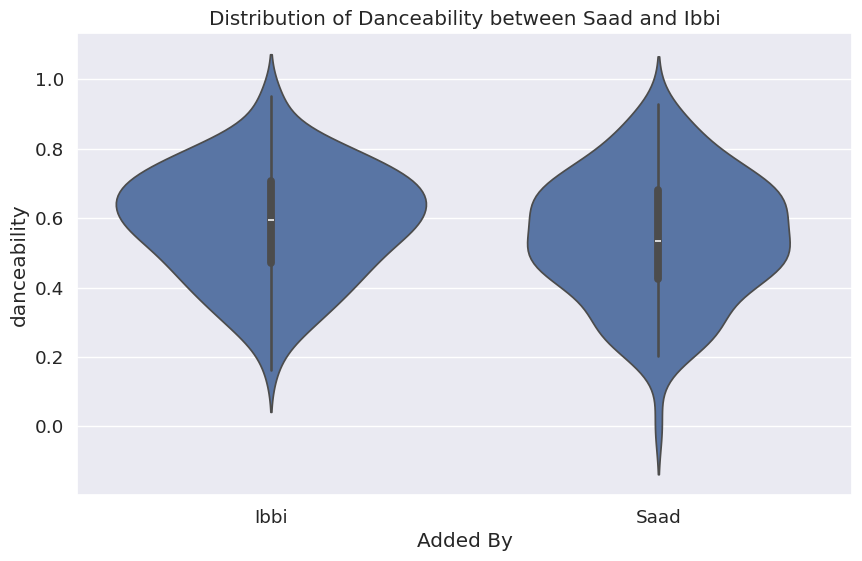

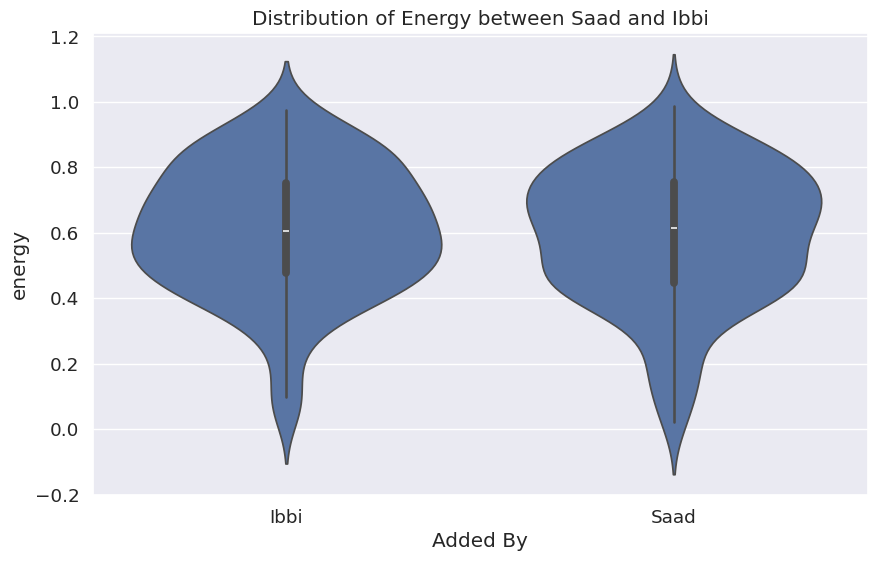

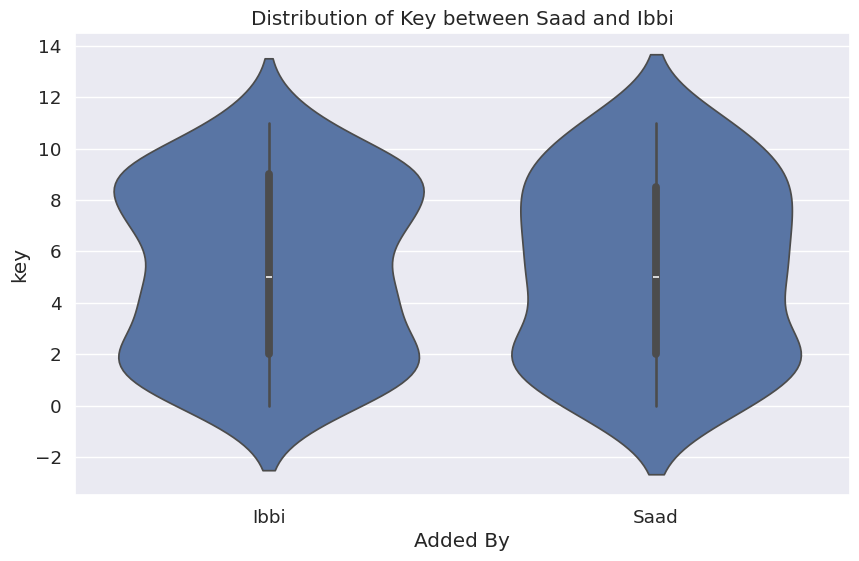

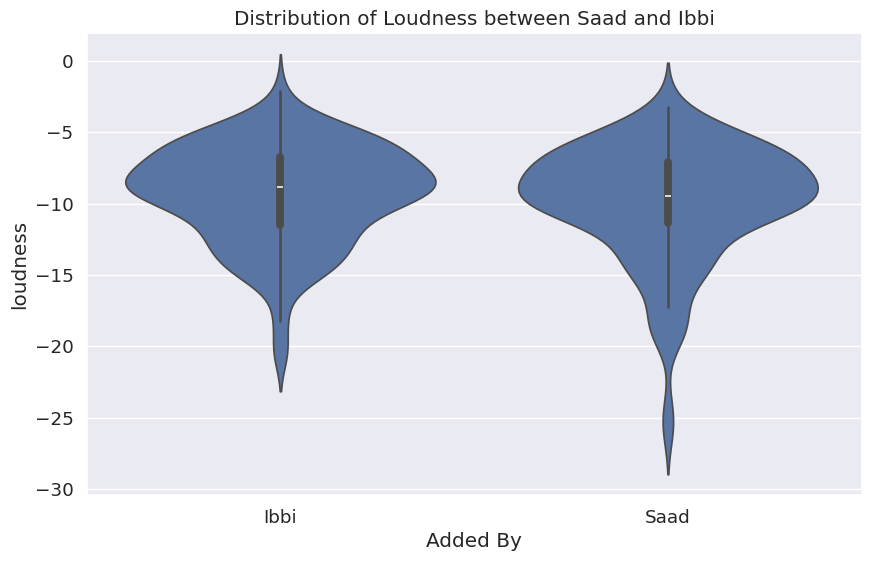

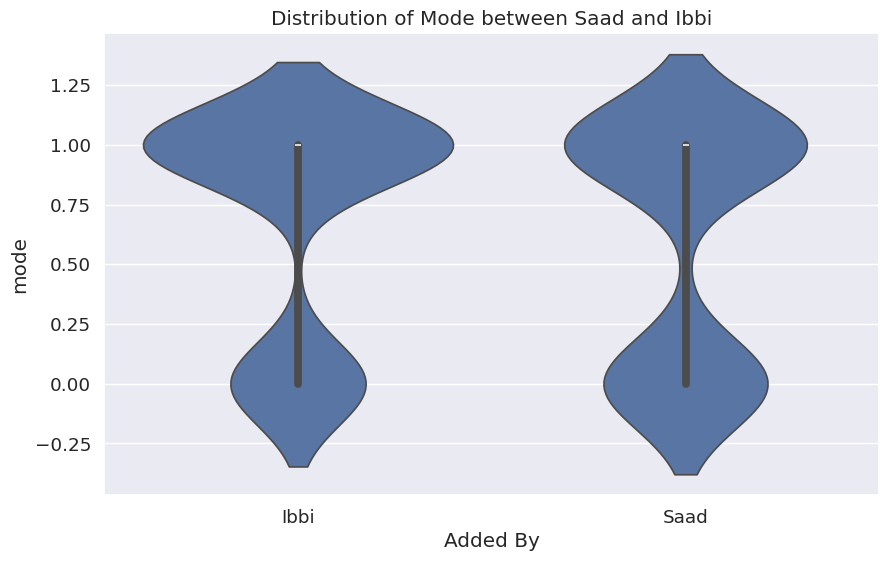

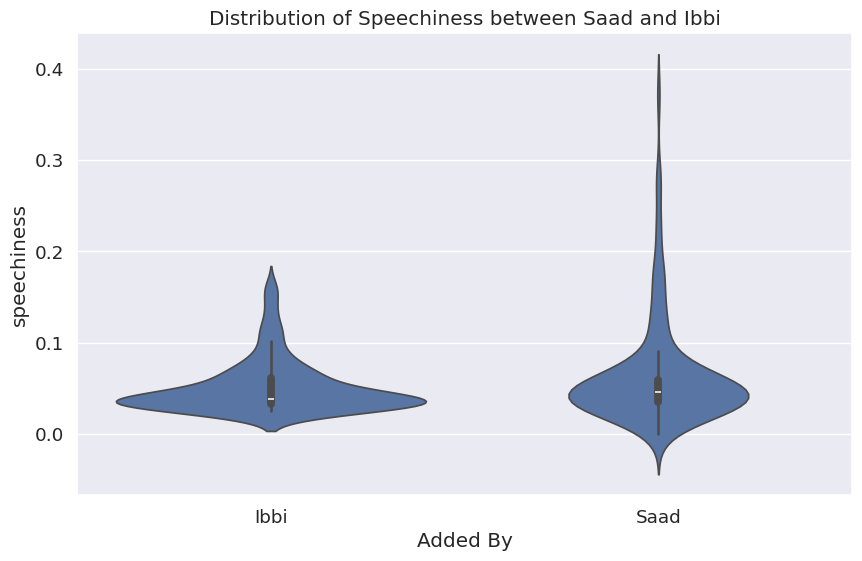

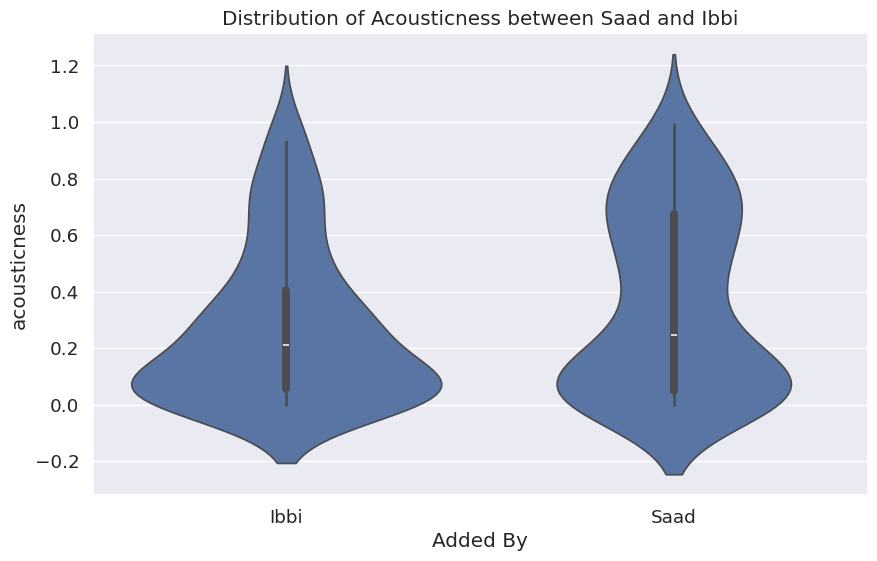

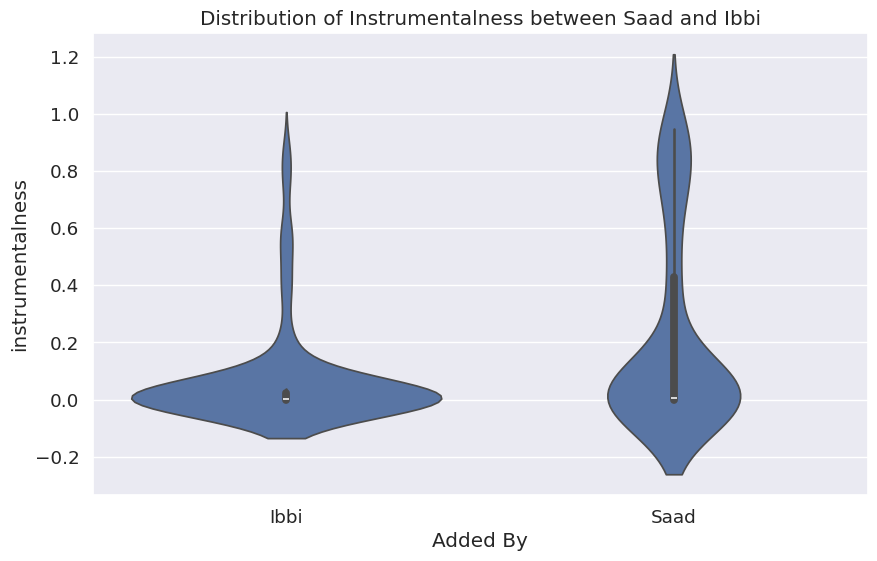

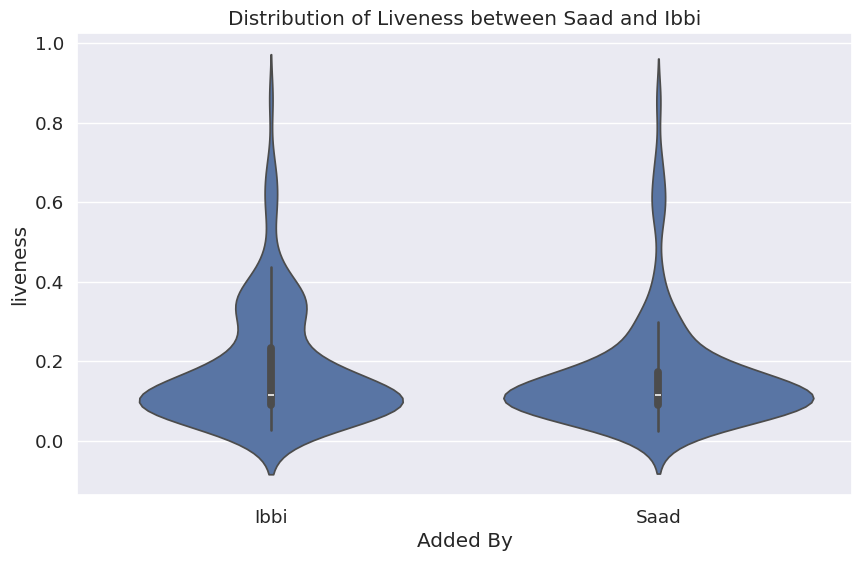

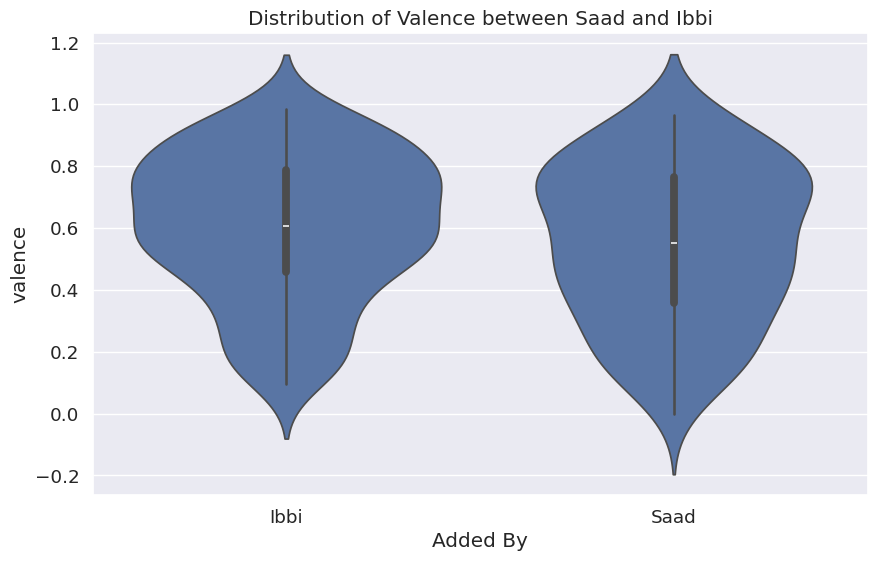

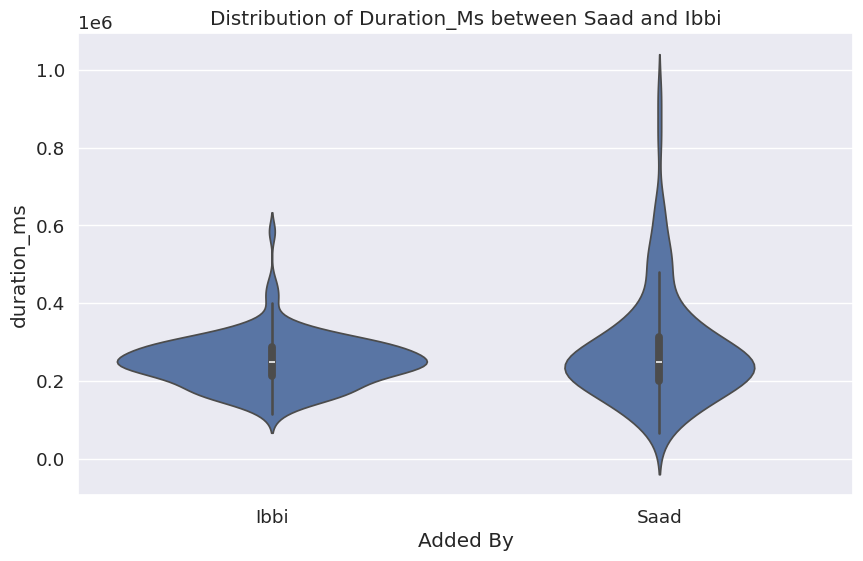

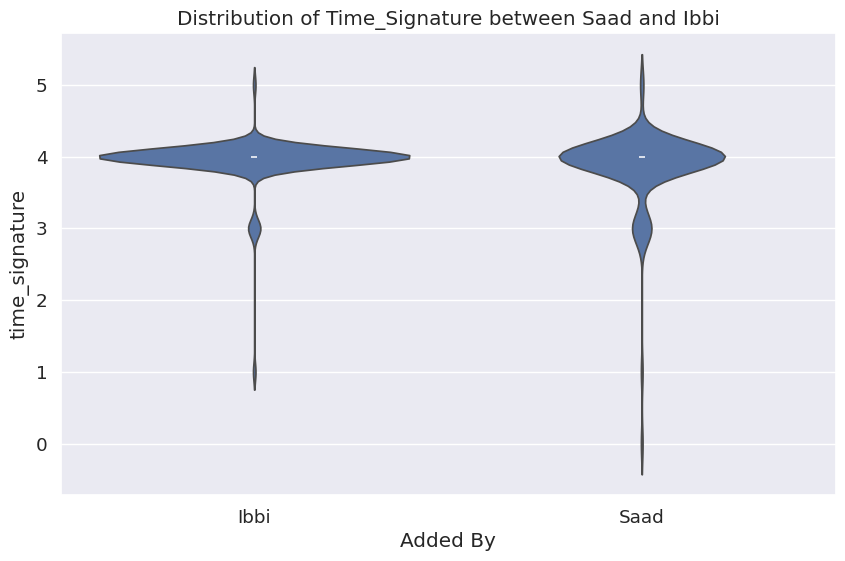

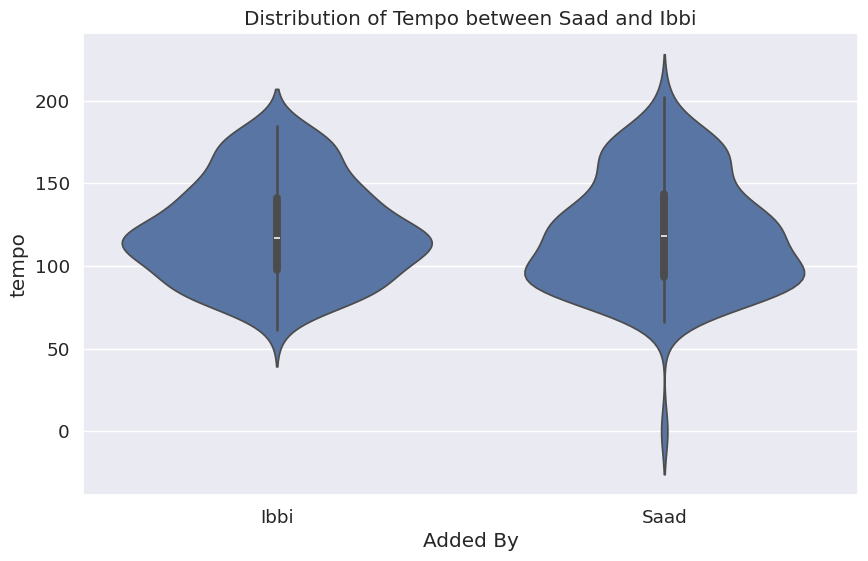

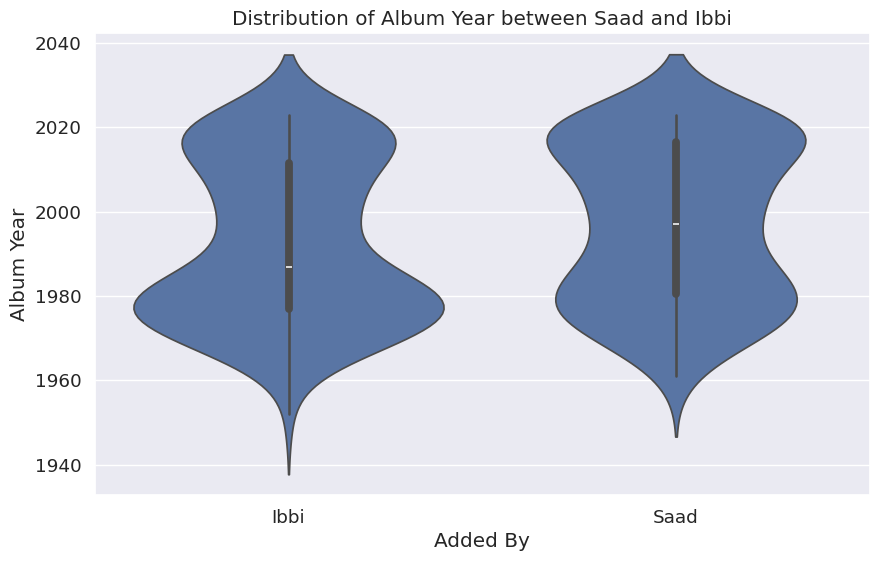

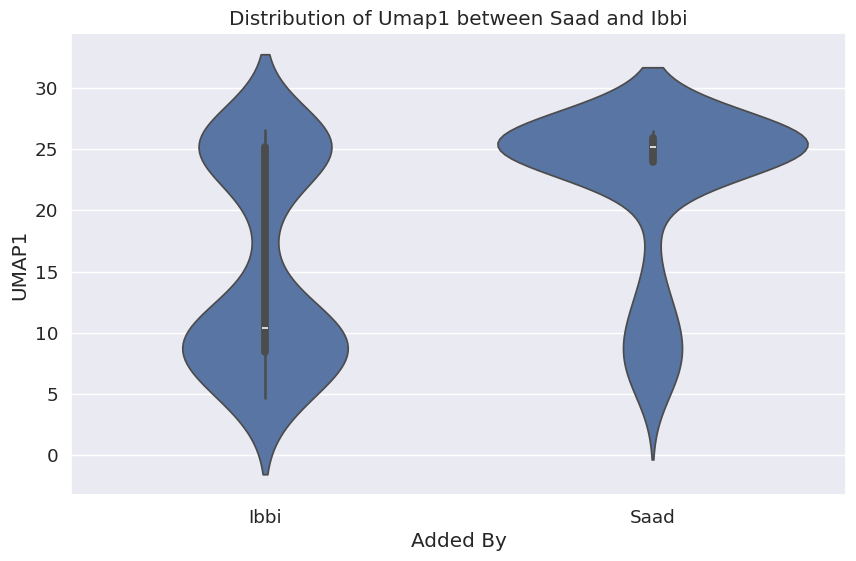

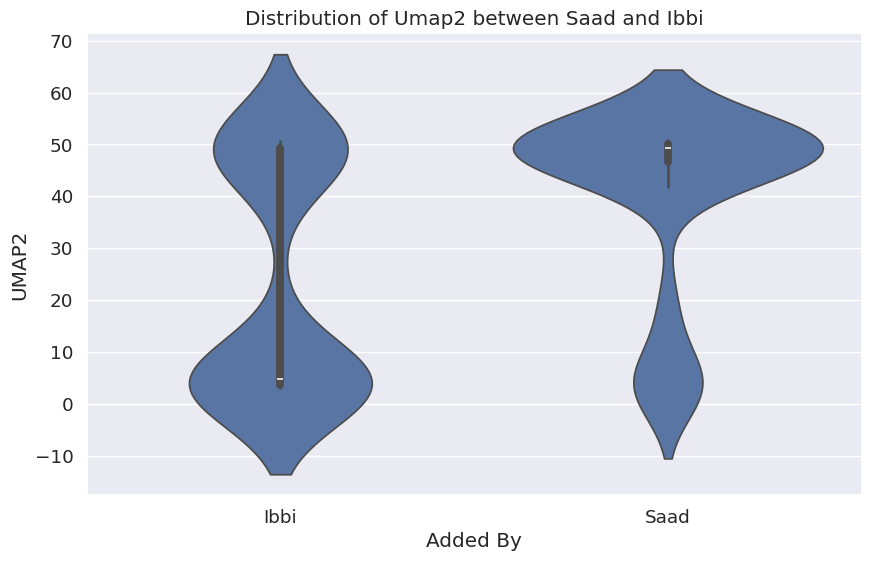

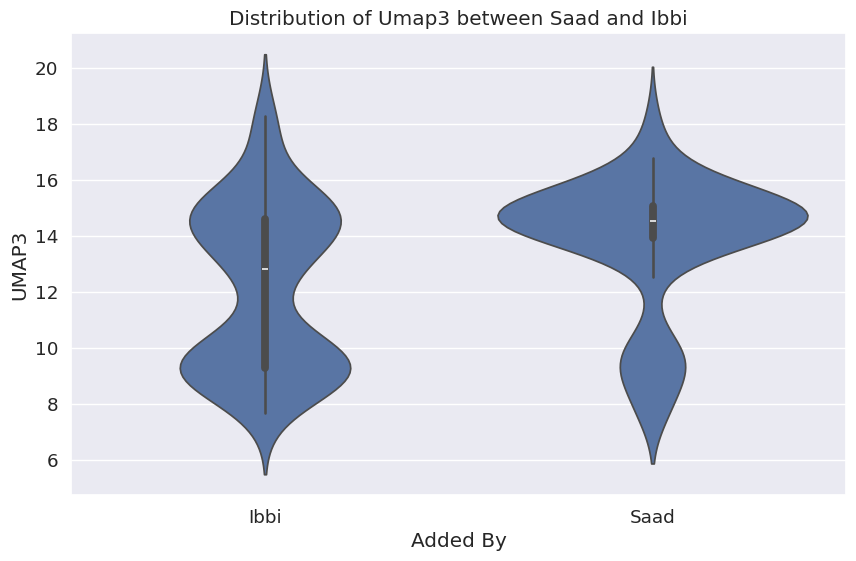

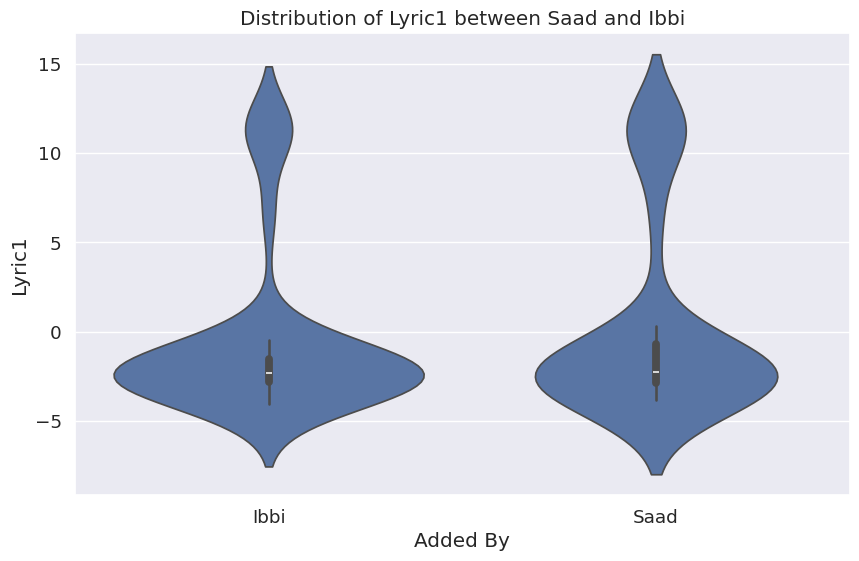

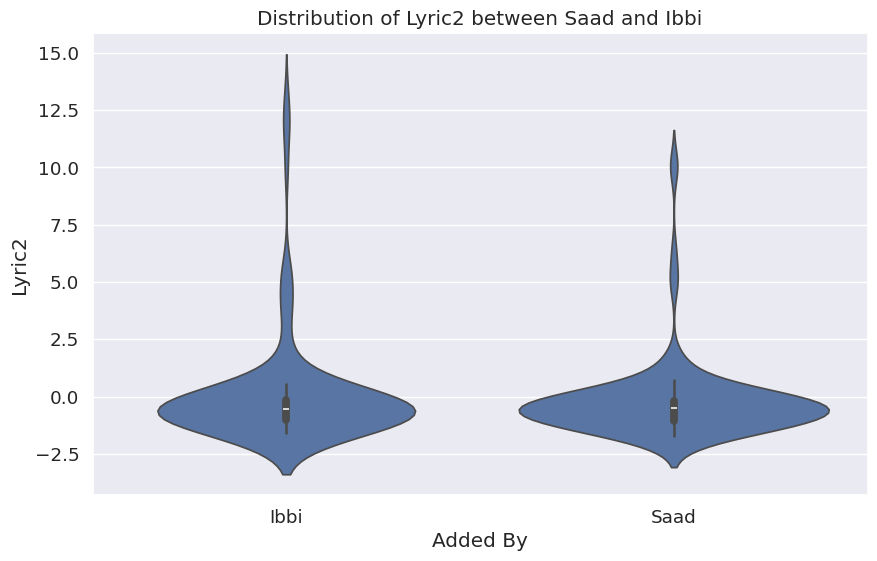

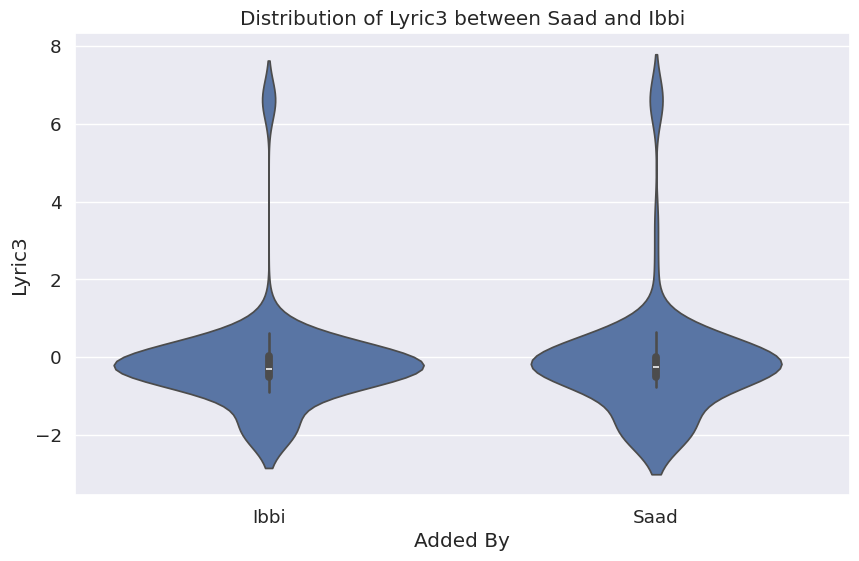

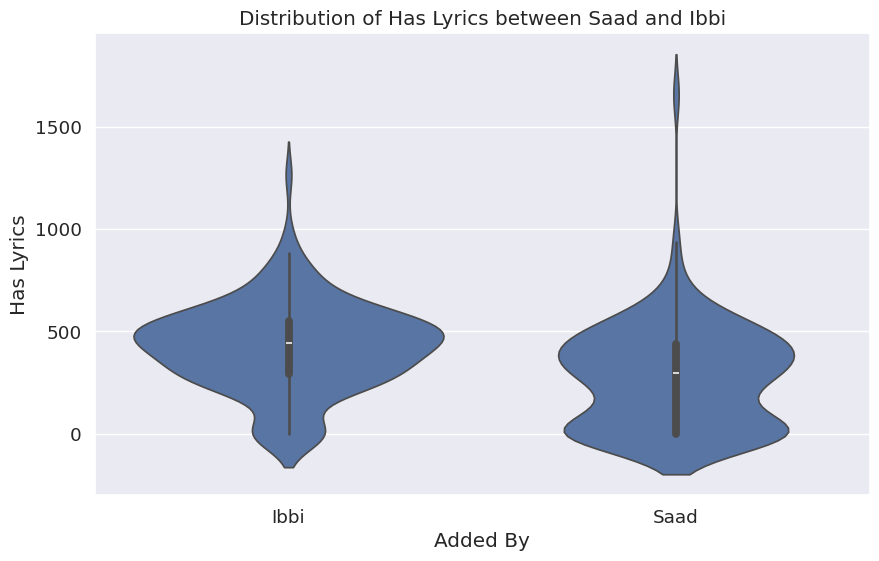

In [ ]:
# Filter the DataFrame to include only training data
train_df = text_data[text_data['Type'] == 'train']

# Splitting the DataFrame based on 'Added By'
tracks_saad = text_data[text_data['Added By'] == 'Saad']
tracks_ibbi = text_data[text_data['Added By'] == 'Ibbi']

# List of metrics to plot
metrics = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'duration_ms', 'time_signature', 'tempo', 'Album Year', 'UMAP1', 'UMAP2', 'UMAP3', 'Lyric1', 'Lyric2', 'Lyric3', 'Has Lyrics']

# Create violin plots for each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Added By', y=metric, data=train_df)
    plt.title(f'Distribution of {metric.title()} between Saad and Ibbi')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


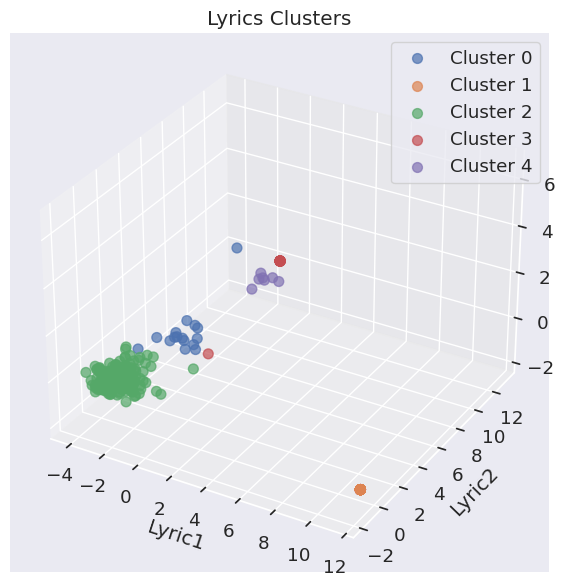

In [ ]:
# Step 1: Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
text_data['Cluster'] = kmeans.fit_predict(text_data[['Lyric1', 'Lyric2', 'Lyric3']])

# Step 2: Plotting the clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Color map for clusters
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']

# Plot each cluster with a different color
for i in range(kmeans.n_clusters):
    cluster_data = text_data[text_data['Cluster'] == i]
    ax.scatter(cluster_data['Lyric1'], cluster_data['Lyric2'], cluster_data['Lyric3'], s=50, label=f'Cluster {i}', alpha=0.7)

ax.set_xlabel('Lyric1')
ax.set_ylabel('Lyric2')
ax.set_zlabel('Lyric3')
ax.legend()
plt.title('Lyrics Clusters')
plt.show()

In [ ]:
# Count 'Saad' and 'Ibbi' in each cluster
cluster_composition = text_data.groupby('Cluster')['Added By'].value_counts().unstack().fillna(0)[['Saad', 'Ibbi']]

# Step 4: Calculate the percentage of 'Saad' and 'Ibbi' in each cluster
cluster_composition_percentage = cluster_composition.apply(lambda x: x / x.sum() * 100, axis=1)

# Displaying the percentage composition of each cluster
print(cluster_composition_percentage)

Added By       Saad       Ibbi
Cluster                       
0         31.250000  68.750000
1         55.102041  44.897959
2         49.800797  50.199203
3         66.666667  33.333333
4         28.571429  71.428571


**Using BERT directly**

An alternative approach we explored was leveraging the same BERT model, but this time fine-tuning it with our data to predict who added a song. Our methodology involved tokenizing the lyrics to create a dataset, which was input into the BERT model for fine-tuning. Given that BERT is built on the transformer architecture utilizing the attention mechanism, a large and complex model designed for understanding the nuances of natural language, this process was inherently slow. We used Google Colab's GPUs to expedite the fine-tuning, capitalizing on BERT's strength in processing text data, including lyrics, by taking advantage of its ability to work with embeddings directly rather than through data compression.

BERT, or Bidirectional Encoder Representations from Transformers, distinguishes itself by reading the entire sequence of words simultaneously rather than sequentially. This bi-directionality, more accurately described as non-directionality, allows the model to learn the context of a word based on its surroundings, enhancing its understanding of language's nuances. The fine-tuning phase involves adapting the pre-trained BERT model to our specific task by adding a final layer tailored to our classification needs and then training the model on our dataset. This adjusts the weights from BERT's general language understanding to our specialized task of song addition prediction.

[DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert), a streamlined version of BERT, was surprisingly effective for this task, achieving accuracy in the mid-60% range, surpassing previous attempts using dimensionality reduction. This variant maintains much of BERT's original model's predictive power but is lighter and faster, making it ideal for environments with limited computational resources (like mine). We further leveraged DistilBERT to generate probability value predictions for each song, integrating these with other features for enhanced prediction accuracy.

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from transformers import DistilBertTokenizer
import torch.nn.functional as F

In [ ]:
# Set up Tokenizer and Classification models
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Fill any missing values
text_data['Lyrics'] = text_data['Lyrics'].fillna('')
# Ensure all values are strings (convert numbers and other types to strings)
lyrics = text_data['Lyrics'].apply(lambda x: str(x) if not isinstance(x, str) else x)

In [ ]:
# Unique mapping for string labels to integers
unique_labels = text_data['Added By'].unique()
label_to_int = {label: i for i, label in enumerate(unique_labels)}

# Split data into train and test
train_data = text_data[text_data['Type'] == 'train']
test_data = text_data[text_data['Type'] == 'test']

# Convert train and test labels
train_labels = [label_to_int[label] for label in train_data['Added By'].tolist()]
test_labels = [label_to_int.get(label, -1) for label in test_data['Added By'].tolist()]

# Tokenize
train_encodings = tokenizer(train_data['Lyrics'].tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_data['Lyrics'].tolist(), truncation=True, padding=True, max_length=512, return_tensors="pt")

In [ ]:
class LyricsDataset(Dataset):
    """
    A custom PyTorch Dataset for lyrics. This dataset is designed to work with BERT encodings and labels.

    Parameters:
    - encodings (dict): Tokenized encodings from the BERT tokenizer.
    - labels (list): The labels for each encoding, typically as integers representing different categories.
    """
    def __init__(self, encodings, labels):
        # Initialize the dataset with BERT encodings and corresponding labels.
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Retrieves an item at the specified index `idx` from the dataset.

        Parameters:
        - idx (int): The index of the item to retrieve.

        Returns:
        - item (dict): A dictionary containing the encoding and label for the item at index `idx`.
                       The encoding is converted to a tensor, and the label is also converted to a long tensor.
        """
        # Fetch the encoding for the specified index and convert each tensor in the encoding to a PyTorch tensor.
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the current item to the dictionary and ensure it's a long tensor.
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        """
        Returns the total number of items in the dataset.

        Returns:
        - The size of the dataset.
        """
        # Return the number of labels, which corresponds to the size of the dataset.
        return len(self.labels)

In [ ]:
# Instantiate datasets
train_dataset = LyricsDataset(train_encodings, train_labels)
test_dataset = LyricsDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Set up the device for GPU if available, otherwise use CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the appropriate device.
model.to(device)

# Initialize the optimizer, using AdamW which is recommended for BERT models, with a specified learning rate.
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# Define the number of epochs for training.
num_epochs = 3

# Start the training loop.
for epoch in range(num_epochs):
    # Set the model to training mode.
    model.train()
    # Initialize a variable to track the cumulative loss.
    train_loss = 0
    # Iterate over batches of data from the training loader.
    for batch in tqdm(train_loader):
        # Clear any previously calculated gradients before performing a backward pass.
        optimizer.zero_grad()
        # Move the batch data to the appropriate device.
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # Perform a forward pass through the model.
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        # Extract the loss from the model's output.
        loss = outputs.loss
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Update the model's parameters.
        optimizer.step()
        # Accumulate the loss over the epoch.
        train_loss += loss.item()
    # Print the average loss for the epoch.
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader)}")

  0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-324-9c5f99c78ed1>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 32/32 [00:11<00:00,  2.72it/s]


Epoch 1/3, Loss: 0.6722306683659554


100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Epoch 2/3, Loss: 0.5701497029513121


100%|██████████| 32/32 [00:12<00:00,  2.62it/s]

Epoch 3/3, Loss: 0.40189833543263376


In [ ]:
def evaluate(model, data_loader):
    """
    Evaluates the model's accuracy on a given dataset.

    Parameters:
    - model: The trained model to evaluate.
    - data_loader: DataLoader object providing the dataset for evaluation.

    Returns:
    - accuracy: The accuracy of the model on the dataset.
    """
    # Switch model to evaluation mode. This turns off specific layers/parts like dropout layers.
    model.eval()
    # Initialize lists to store the model predictions and the actual labels.
    predictions, true_labels = [], []
    # Disable gradient calculation to save memory and computations, speeding up evaluation.
    with torch.no_grad():
        for batch in data_loader:
            # Move batch data to the appropriate device.
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # Perform a forward pass with the model to get predictions.
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            # Extract the index of the highest logit to get the most likely label.
            predictions.extend(torch.argmax(logits, dim=-1).tolist())
            # Store the true labels.
            true_labels.extend(labels.tolist())
    # Calculate the accuracy of predictions compared to the true labels.
    accuracy = accuracy_score(true_labels, predictions)
    # Return the calculated accuracy.
    return accuracy

# Evaluate the model on the test dataset and print the accuracy.
accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {accuracy}")

<ipython-input-324-9c5f99c78ed1>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Test Accuracy: 0.7142857142857143


In [ ]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [ ]:
def preprocess_texts(texts):
    """
    Tokenizes and preprocesses a list of texts according to the model's requirements.

    Parameters:
    - texts (list of str): The texts to preprocess.

    Returns:
    - A dictionary containing the tokenized texts, ready for input into the model.
    """
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

def predict_probabilities(model, texts):
    """
    Predicts the probabilities of each class for given texts using the specified model.

    Parameters:
    - model: The trained model for prediction.
    - texts (list of str): The texts to predict probabilities for.

    Returns:
    - A list of probability distributions across classes for each text.
    """
    # Ensure the model is in evaluation mode.
    model.eval()
    # No gradient needed for prediction, to save memory and computation.
    with torch.no_grad():
        # Preprocess texts to be suitable for model input.
        inputs = preprocess_texts(texts)
        # Move inputs to the same device as the model.
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        # Get model outputs.
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # Calculate probabilities from logits.
        probabilities = F.softmax(logits, dim=1).tolist()
    return probabilities[0]

# Predict and store probabilities for each lyric in the DataFrame.
text_data['Prediction_Probabilities'] = text_data['Lyrics'].apply(lambda x: predict_probabilities(model, [x])[0])

In [ ]:
text_data.to_csv('final.csv', index=False)

**XGBoost**

XGBoost stands out especially when dealing with a significant number of quantitative numerical features like we are. It employs regularization techniques, such as L1 and L2 regularization and pruning, to prevent overfitting. This is particularly crucial due to the high dimensionality of the data. Unlike random forests used in the first pipeline, which build trees independently, XGBoost adds trees sequentially, with each new tree correcting the errors made by the previously added trees, an approach known as gradient boosting. Combined with XGBoost's unique tree-pruning strategy, this ensures more efficient and effective modeling.

XGBoost's advanced optimization techniques and parallel processing capabilities significantly enhance computational efficiency. Its ability to continuously learn from mistakes allows it to handle complex and nonlinear relationships within the data effectively. This iterative refinement, coupled with a focus on model efficiency and accuracy, makes XGBoost a preferred choice for binary classification tasks.

**Pseudocode for XGBoost with Regularization**

- Initialize model with a single leaf
- for each round of boosting do:
  - Predict the gradient of loss with respect to predictions
  - Fit a new model to these gradients
  - Apply regularization:
  - For L1 (Lasso Regression): penalty = alpha * |w|
  - For L2 (Ridge Regression): penalty = lambda * w^2
  - Update the model by adding the new model weighted by learning rate
  - Prune trees based on gain calculations
- end for
- Output the final model


**Regularization in XGBoost**

Regularization helps in reducing overfitting. In the context of XGBoost, two main types of regularization are employed:

- **L1 Regularization (Lasso Regression)**: Adds a penalty equal to the absolute value of the magnitude of coefficients.

$$\text{Penalty}_{\text{L1}} = \alpha \sum |w_j|$$

- **L2 Regularization (Ridge Regression)**: Adds a penalty equal to the square of the magnitude of coefficients.

$$\text{Penalty}_{\text{L2}} = \lambda \sum w_j^2$$

Where w_j represents the coefficients of the model features, alpha is the parameter that controls the strength of the L1 regularization, and lambda controls the strength of the L2 regularization. These parameters can be tuned to effectively reduce overfitting, making XGBoost a powerful tool for binary classification tasks in datasets with a large number of features.

### **Part VI: Model Training**

I defined a function to evaluate model performance across various combinations of features to identify those that lead to the best performance, specifically determining which features encode information about who added the song.

As seen below, incorporating genre information leads to a significant jump in predictive power, followed by improved performance by including lyric length as a feature (lyrics alone do not help model performance), and finally, using BERT probability predictions leads to the best performance, although the differences can be marginal.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
def tune_and_evaluate_xgboost(features, text_data):
    """
    Perform hyperparameter tuning and evaluation for an XGBoost classifier.

    Parameters:
    - features: list of strings, names of the features to include from `text_data`.
    - text_data: DataFrame, must contain the features, 'Added By', and 'Type' columns.

    This function prints the best hyperparameters and cross-validation accuracy,
    and it returns the accuracy on the test set.
    """
    # Selecting features and target
    X = text_data[features]
    y = text_data['Added By']

    # Encode the target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Splitting data into features and target based on 'Type'
    X_train = X[text_data['Type'] == 'train']
    X_test = X[text_data['Type'] == 'test']
    y_train = y_encoded[text_data['Type'] == 'train']
    y_test = y_encoded[text_data['Type'] == 'test']

    # Define the parameter grid for XGBoost
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0]
    }

    # Setup cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize GridSearchCV
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best parameters and score
    best_parameters = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best parameters: {best_parameters}")
    print(f"Best cross-validation accuracy: {best_score * 100:.2f}%")

    # Evaluate the model with the best parameters on the test set
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy: {accuracy * 100:.2f}%")

    # Assuming `grid_search` is your fitted GridSearchCV object
    best_index = grid_search.best_index_
    fold_accuracies = [grid_search.cv_results_[f'split{i}_test_score'][best_index] for i in range(kfold.get_n_splits())]
    print(f"Fold accuracies for the best model: {['{:.2f}%'.format(acc * 100) for acc in fold_accuracies]}")

In [ ]:
# Without UMAP
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness',
            'duration_ms', 'Album Year']
test_accuracy = tune_and_evaluate_xgboost(features, text_data)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
Best cross-validation accuracy: 67.69%
Test set accuracy: 65.48%
Fold accuracies for the best model: ['72.55%', '66.67%', '68.63%', '70.59%', '60.00%']


In [ ]:
# With UMAP
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness',
            'duration_ms', 'Album Year', 'UMAP1', 'UMAP2', 'UMAP3']
test_accuracy = tune_and_evaluate_xgboost(features, text_data)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.9}
Best cross-validation accuracy: 73.59%
Test set accuracy: 70.24%
Fold accuracies for the best model: ['80.39%', '80.39%', '70.59%', '70.59%', '66.00%']


In [ ]:
# With Lyrics Semantic data
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness',
            'duration_ms', 'Album Year', 'UMAP1', 'UMAP2', 'UMAP3', 'Lyric1', 'Lyric2', 'Lyric3']
test_accuracy = tune_and_evaluate_xgboost(features, text_data)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation accuracy: 71.26%
Test set accuracy: 67.86%
Fold accuracies for the best model: ['76.47%', '74.51%', '68.63%', '64.71%', '72.00%']


In [ ]:
# Combining both Lyrics Length and semantic information
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness',
            'duration_ms', 'Album Year', 'UMAP1', 'UMAP2', 'UMAP3', 'Lyric1', 'Lyric2', 'Lyric3', 'Has Lyrics']
test_accuracy = tune_and_evaluate_xgboost(features, text_data)

Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation accuracy: 72.86%
Test set accuracy: 71.43%
Fold accuracies for the best model: ['74.51%', '78.43%', '62.75%', '68.63%', '80.00%']


In [ ]:
# Using predicitons from the BERT model
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness',
            'duration_ms', 'Album Year', 'UMAP1', 'UMAP2', 'UMAP3', 'Prediction_Probabilities']
test_accuracy = tune_and_evaluate_xgboost(features, text_data)

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation accuracy: 94.10%
Test set accuracy: 73.81%
Fold accuracies for the best model: ['94.12%', '94.12%', '92.16%', '94.12%', '96.00%']


### **Part VII: Model Performance**

Compared to Pipeline I, which achieved a performance of 69% using random forest and 70% accuracy without incorporating lyrics data or similar features using XGBoost, utilizing the feature, prediction probabilities from fine-tuned BERT resulted in a 73% test accuracy. Naturally, having been fine-tuned on training data, its performance across k-folds on the training data was anomalously high (90%) since it had seen the data before. Yet, this still translated to a high test score, which was blind, suggesting this is likely the most optimal approach.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

In [ ]:
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness',
            'duration_ms', 'Album Year', 'UMAP1', 'UMAP2', 'UMAP3', 'Prediction_Probabilities']
target = 'Added By'

# Extracting features and target from the DataFrame
X = text_data[features]
y = text_data[target]

# Encoding the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset based on 'Type'
X_train = X[text_data['Type'] == 'train']
X_test = X[text_data['Type'] == 'test']
y_train = y_encoded[text_data['Type'] == 'train']
y_test = y_encoded[text_data['Type'] == 'test']

Test set accuracy: 73.81%
Classification Report:
              precision    recall  f1-score   support

        Ibbi       0.63      0.85      0.72        34
        Saad       0.87      0.66      0.75        50

    accuracy                           0.74        84
   macro avg       0.75      0.76      0.74        84
weighted avg       0.77      0.74      0.74        84

Confusion Matrix:
[[29  5]
 [17 33]]


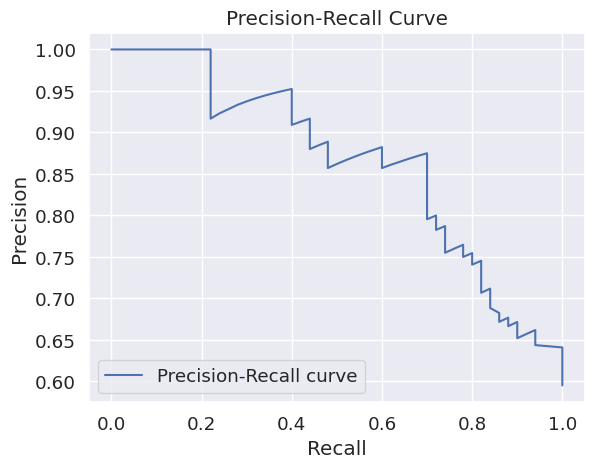

AUC of Precision-Recall Curve: 0.86


In [ ]:
# Best parameters from tuning
best_params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}

# Redefine the model with the best parameters
model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss')

# Train the model on the entire training dataset
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Precision-Recall Curve
y_scores = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Calculate the AUC
auc_precision_recall = auc(recall, precision)
print(f"AUC of Precision-Recall Curve: {auc_precision_recall:.2f}")

### **Part VIII: Results and Discussion**

Incorporating semantic information about lyrics data proved to be very useful. For instance, in Pipeline I, the main issue was many of my songs being falsely classified as Ibbi's. Still, with the new approach, the number of false positives decreased sharply, suggesting that I listen to different types of lyrics, which could be identified using sentiment analysis using finetuned versions of BERT in future pipelines.

This improvement is likely the result of incorporating semantic data, as aspects like the number of lyrics and other metadata are already factored into features like speeches and instrumentals of a song, which show some variation between Ibbi and me. The increase in accuracy is attributed to the new information captured from the semantics through the BERT model. Unlike pooling embeddings, the BERT model is not lossy, enabling it to capture this nuanced information better.

The general improvement in seperability between the song preferences with an increase in the AUC score, shows our new model is better.

| Pipeline | Model          | Lyric Features | Accuracy | F1 Weighted Average | AUC  |
|----------|----------------|----------------|----------|---------------------|------|
| **I**        | Random Forest  | No             | 65%      | 0.63                | 0.81 |
| **II**        | XGBoost        | Yes            | 73%      | 0.74                | 0.86 |


### **Part IX: Summary**

We have improved our predictive performance by using the model attached [here](https://www.canva.com/design/DAGApb-srjQ/oCKG4LIG56fv92wmkQ67wg/edit?utm_content=DAGApb-srjQ&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton) (collab won't let me embed directly). A future direction is to use BERT for sentiment analysis of the lyrics data or employ data augmentation to achieve even better accuracy scores. However, the approach I am most interested in is exploring different model architectures, including those in the literature, and ideally developing a new one with some modifications to generate lyric data.

While handling NLP data, I found this [book](https://web.stanford.edu/~jurafsky/slp3/), which I am still reading, an excellent guide that provides step-by-step processes like tokenization, how embeddings are generated, LSTM, transformers, and everything in between. I plan to apply more concepts from this guide in the future in terms of learning and understanding the underlying theoretical concepts of NLP.

### **Part X: References**

“Distilbert.” DistilBERT, huggingface.co/docs/transformers/model_doc/distilbert. Accessed 26 Mar. 2024.

Gomede, Everton. “A Comparative Analysis of Dimensionality Reduction Techniques in Machine Learning.” Medium, 𝐀𝐈 𝐦𝐨𝐧𝐤𝐬.𝐢𝐨, 6 Mar. 2024, medium.com/aimonks/a-comparative-analysis-of-dimensionality-reduction-techniques-in-machine-learning-3389c5103348.

Jurafsky, Dan, and James H. Martin. Speech and Language Processing. Prentice Hall, Pearson Education International, 2014.

Ke, Ashley, et al. Predicting Metadata from Song Lyrics Using NLP, slolla.github.io/files/nlp.pdf. Accessed 26 Mar. 2024.

McInnes, Leland, et al. “UMAP: Uniform manifold approximation and projection.” Journal of Open Source Software, vol. 3, no. 29, 2 Sept. 2018, p. 861, https://doi.org/10.21105/joss.00861.

**AI Statement:** AI was used to help write code for the BERT implementations since I am not familiar with working with LLM models directly.

# **Generative Model**

Extending this work to include the generation of lyrics is a complex challenge, given that lyrics encompass factors such as rhyme, meter, and structure. For processing this type of data, Long Short-Term Memory Networks (LSTMs), a specialized kind of Recurrent Neural Networks (RNNs) with the ability to consider previous sequential inputs through context windows, are particularly useful.

LSTMs are widely employed in text-generation tasks. However, advancements have been made by incorporating architectures like Variational Autoencoders (VAEs) with LSTM layers, a concept first introduced for text generation by [Bowman et al.](https://arxiv.org/pdf/1511.06349.pdf) in 2016. This approach has been applied to various [sequential data generation](https://towardsdatascience.com/time-series-generation-with-vae-lstm-5a6426365a1c) tasks, including lyrics generation from audio data. The key innovation of VAEs in this context is using a bottleneck layer that maps to a Gaussian distribution, facilitating the reparameterization trick. This not only prevents overfitting to the training data but also aids in generating new, creatively valuable data. LSTMs complement this by managing the data's sequential aspect across significant context windows.

VAEs are particularly relevant to my project due to their ability to mitigate overfitting, a notable challenge in LSTM-based generation, especially given that my prototype operates on a training dataset of just 270 samples.

Exploring other architectures, I encountered one that combines a convolutional encoder layer with an LSTM decoding layer from [Severyn et. al](https://ar5iv.labs.arxiv.org/html/1702.02390). Despite my initial skepticism—given that Convolutional Neural Networks (CNNs) are generally less adept at managing complex sequential dependencies than LSTMs—this approach outperformed Bowman's, according to the literature. Additional architectures, such as the [Topic-Guided Variational Autoencoders](https://aclanthology.org/N19-1015.pdf) that employ mixture models for text generation, also seem promising and worth exploring, almost making me glad I took CS146.

Given the power of Transformer models in NLP tasks, I am also considering experimenting with architectures that incorporate attention mechanisms. There is still much for me to learn, theoretically and regarding engineering adjustments.

This is an initial draft of a model that mirrors the approach of Bowman et al., incorporating both LSTM encoder and decoder layers. However, its performance could be much better. The dataset is relatively small, containing approximately 270 entries with a vocabulary size of around 3,500, including non-English lyrics and English ones. It needs better preprocessing, such as lemmatization. Additionally, the model's size (32 LSTMs) is constrained due to the limited amount of data, precluding a more extensive, potentially more effective model since LSTMs are computationally expensive to train and large models would underfit.

To test the model's functionality, I've employed many training epochs to intentionaly overfit the data for now. Moving forward, I aim to utilize a dataset that is not only larger but also meticulously cleaned and prepared specifically for machine learning purposes. This includes employing word embeddings to provide a richer representation of the data, utilizing a larger model to capture the intricacies of the data better, exploring different architectural choices, and working with a much larger dataset, possibly sourced from platforms like MusicMatch or a custom Kaggle dataset.

Despite these clear limitations, the model's text generation outcomes are presented below.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, Dense, Embedding, Flatten, LSTM
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import random
from tensorflow.keras import layers

In [ ]:
# Filter out empty lyrics and lyrics with placeholder value "0.5", then convert to lowercase
lyrics = [lyric.lower().replace("...", "") for lyric in text_data["Lyrics"] if lyric not in ["", "0.5"]]

# Instantiate the tokenizer and fit it on the lyrics
tokenizer = Tokenizer(num_words=3586, oov_token="<OOV>")
tokenizer.fit_on_texts(lyrics)

# Convert text to sequence of integers and pad sequences
sequences = tokenizer.texts_to_sequences(lyrics)
max_sequence_length = 364 # Found from data
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

In [ ]:
# Define the Sampling layer used in the VAE
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_variational_lstm(latent_dim, max_sequence_length, vocabulary_size):
    # Encoder architecture
    encoder_inputs = layers.Input(shape=(max_sequence_length,))
    x = layers.Embedding(input_dim=vocabulary_size, output_dim=32)(encoder_inputs)  # Embedding layer
    x = layers.LSTM(32, return_sequences=True)(x)  # First LSTM layer with return_sequences=True for stacking
    x = layers.LSTM(16)(x)  # Second LSTM layer to compress sequence information
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)  # Latent space mean
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)  # Latent space variance

    # Reparameterization trick
    z = Sampling()([z_mean, z_log_var])

    # Decoder architecture
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.RepeatVector(max_sequence_length)(decoder_inputs)  # Prepares the fixed-length sequence input
    x = layers.LSTM(16, return_sequences=True)(x)  # First LSTM layer in decoder
    x = layers.LSTM(32, return_sequences=True)(x)  # Second LSTM layer to expand the sequence
    decoder_outputs = layers.TimeDistributed(layers.Dense(vocabulary_size, activation='softmax'))(x)  # Output layer

    # Instantiate the encoder and decoder as separate models
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(decoder_inputs, decoder_outputs, name='decoder')

    # Variational Autoencoder class
    class VAE(Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        def call(self, inputs):
            z_mean, z_log_var, z = self.encoder(inputs)
            reconstructed = self.decoder(z)
            # Compute KL divergence loss and add it to the model
            kl_loss = -0.5 * tf.reduce_mean(
                z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            self.add_loss(kl_loss)
            return reconstructed

    # Instantiate and compile the VAE model
    vae = VAE(encoder, decoder)
    vae.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

    return vae

In [ ]:
# Derived from data
latent_dim = 10
max_sequence_length = 364
vocabulary_size = 3586

# Build the variational LSTM model
vae = build_variational_lstm(latent_dim, max_sequence_length, vocabulary_size)

# Train the model
vae.fit(padded_sequences, padded_sequences, epochs=25, batch_size=32)

Epoch 1/25
9/9 [==============================] - 14s 211ms/step - loss: 8.1740
Epoch 2/25
9/9 [==============================] - 3s 361ms/step - loss: 8.1342
Epoch 3/25
9/9 [==============================] - 2s 182ms/step - loss: 8.0262
Epoch 4/25
9/9 [==============================] - 2s 190ms/step - loss: 7.6530
Epoch 5/25
9/9 [==============================] - 2s 173ms/step - loss: 7.0488
Epoch 6/25
9/9 [==============================] - 1s 152ms/step - loss: 6.3335
Epoch 7/25
9/9 [==============================] - 2s 184ms/step - loss: 5.5935
Epoch 8/25
9/9 [==============================] - 1s 150ms/step - loss: 4.8795
Epoch 9/25
9/9 [==============================] - 2s 237ms/step - loss: 4.1473
Epoch 10/25
9/9 [==============================] - 2s 178ms/step - loss: 3.5107
Epoch 11/25
9/9 [==============================] - 2s 194ms/step - loss: 2.9754
Epoch 12/25
9/9 [==============================] - 1s 163ms/step - loss: 2.6258
Epoch 13/25
9/9 [==============================]

In [ ]:
# Sampling new tokens
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-7) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)  # Normalize the predictions to form a probability distribution
    probas = np.random.multinomial(1, preds, 1)  # Sample one token from the multinomial distribution
    return np.argmax(probas)  # Return the index of the sampled token

def generate_song_lyrics(model, tokenizer, seed_text="I", max_sequence_length=100, num_words_to_generate=5, temperature=1):
    generated_text = seed_text
    words_generated = 0

    while words_generated < num_words_to_generate:
        # Prepare the input sequence
        sequence = tokenizer.texts_to_sequences([generated_text])
        sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')

        # Generate predictions for the next word
        predictions = model.predict(sequence)[0, -1, :]  # Focus on the last timestep's output

        next_token = sample(predictions, temperature=temperature)  # Sample a token index based on predictions

        # Convert the token index back to a word
        next_word = tokenizer.index_word.get(next_token, None)

        if next_word is None or next_word == "<OOV>":
            continue  # Skip adding the word if it's out-of-vocabulary (OOV)

        generated_text += " " + next_word  # Add the generated word to the output text
        words_generated += 1

    return generated_text

In [ ]:
# Generate Lyrics
generated_lyrics = generate_song_lyrics(vae, tokenizer, "when i first", max_sequence_length)
print(generated_lyrics)

1/1 [==============================] - 0s 33ms/step
when i first to call i got the


In [ ]:
# Clean
lyrics = [lyric.lower() for lyric in text_data["Lyrics"]]
all_lyrics = ' '.join(lyrics).replace("\n", " ")
words = all_lyrics.split()

# Generate 5 random 5-word combinations
for _ in range(5):
    random_combo = ' '.join(random.sample(words, 5))
    print(random_combo)

three, more there's thought are
part (what killer as it)
you tight be musical 'eezer
thing it the feel me
feel for yeah big the


"":

- and the get that club
- acrobats believe prefieraré chained call
- never eyes to n him
- your dreamed back much oh
- sour 내입가에 catch jumps red


"i":

- i you a and ale might
- i art puff you down i
- i introduced corner stick your want
- i pane as without comes away
- i whose oh piscean 21 beg

"just help":

- just help ہنستا the sleepin' and not
- just help of the violent away norwegian
- just help hard a stung am these
- just help town lucky destiny but hundred
- just help of to yeah furniture saves

"when i first":

- when i first seemed tell gonna the remember
- when i first my alienation ya the with
- when i first hide trying oh them exhale
- when i first i war you' feels and
- when i first goode on greetings you too

"":

- i some the stood i
- was the no to the
- night me queria pay hold
- that glass soil, it it
- me am looks brother got


"i":

- i of did come and must
- i indians home left body name
- i want a do high lose
- i have like wanting I will
- i won't up a دھن Oh

"just help":

- just help you I logic's no getting
- just help start of I light crazy
- just help doubt time dreaded you off
- just help sadness shaded pinkie out you
- just help queria you i infinity lover

"when i first":

- when i first sun dance masquerade instead dia
- when i first चलो out you want was
- when i first hard so soñar the know
- when i first the up a on i
- when i first now come hill make to

(The first is LSTM Generated, and the latter is Random.)

Both GPT and my roommate, Stenio, could identify this correctly. My roommate pointed out that the LSTM-generated text follows a noun-verb order. [GPT-4](https://chat.openai.com/share/e/b22c5ebf-6570-4152-9a50-e86477ee0934) observed simple patterns in the data, indicating that my LSTM performs better than random approaches despite its tiny dataset and limited size. It will likely improve further with more data and better architecture. It's important to note that the sequences of words produced by the LSTM model cannot be found in the original data, indicating that it generates new content rather than regurgitative training data.

I should employ more advanced approaches, such as adversarial neural networks or sophisticated NLP metrics, to effectively evaluate the quality of the generated lyrics. These include calculating cosine similarities for the embeddings of the generated text or leveraging perplexity scores to compare the generated lyrics against actual lyrics.



**References**

Bowman, Samuel R., et al. “Generating sentences from a continuous space.” Proceedings of The 20th SIGNLL Conference on Computational Natural Language Learning, 2016, https://doi.org/10.18653/v1/k16-1002.

Cerliani, Marco. “Time Series Generation with VAE LSTM.” Medium, Towards Data Science, 29 Dec. 2020, towardsdatascience.com/time-series-generation-with-vae-lstm-5a6426365a1c.

Semeniuta, Stanislau, et al. “A hybrid convolutional variational Autoencoder for text generation.” Proceedings of the 2017 Conference on Empirical Methods in Natural           Language Processing, 2017, https://doi.org/10.18653/v1/d17-1066.

Wang, Wenlin, et al. “Topic-guided variational auto-encoder for text generation.” Proceedings of the 2019 Conference of the North, 2019, https://doi.org/10.18653/v1/n19-1015.